<a id="toc"></a>
# **Loan Approval Prediction**

Table of Contents:
- [About the Project](#1)
- [About the Data](#2)
- [Set Up](#3)
- [Adversarial Validation: Include Original Data?](#4)
- [Exploratory Data Analysis](#5)
    - [Summary Stats](#5a)
    - [Target Variable & Categorical Features](#5b)
    - [Numerical Features](#5c)
    - [Sweetviz](#5d)
- [Data Preprocessing](#6)
- [LGBM Model w/ Optuna](#7)
- [Model Evaluation](#8)
- [Submission](#9)
- [References](#r)

<a id="toc"></a>

<a href="#2" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="1"></a>
# **About the Project**

The overarching goal of this project is to develop a model to predict whether or not an applicant is approved for a loan. This project has been completed as part of [Kaggle's Playground Series competitions](https://www.kaggle.com/competitions/playground-series-s4e10/overview) (Season 4, Episode 10), and as part of my continued learning of various data science concepts. 

In this project, I will first use adversarial validation to determine whether or not the original data (discussed in the 'About the Data' section) follows the same distribution as Kaggle's synthetic data. This step will likely be a key factor in the final model's performance, as incorporating data from a different distribution can sometimes negatively impact a model's performance on the withheld testing data.

Next, I will briefly explore the datasets by viewing basic summary statistics, visualizing the distributions of the target variable and the categorical and numerical features, and also by using a heatmap to identify any potential correlations amongst features.

Following this, I will prepare the data for modeling. This will be accomplished by encoding all object type features as integers. I will also employ some feature engineering, by creating new features which are essentially ratios of existing features. 

The final model will be a [LightGBM](https://github.com/microsoft/LightGBM) model. LightGBM (LGBM) is a fast, distributed, high performance gradient boosting framework that is based on decision tree algorithms. This type of model is typically effective in classification tasks. LGBM is developed by Microsoft and is publicly available for usage. 

In order to identify the best model, I will use [optuna](https://optuna.org/), which is a hyperparameter optimization framework. Optuna will create and run through 100 trials to determine the ideal hyperparameters for the final LGBM model.

It should also be noted that the target variable 'loan_status' is not evenly distributed (shown in the EDA section). Because of this, I will be using Stratified K-Fold Cross Validation for stratified sampling, instead of random sampling.

The model will be evaluated using the area under the curve (AUC) of the receiver operating characteristic curve (ROC curve). The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is esentially the plot of the true positive rate versus the false positive rate. In the case of this model and competition, a 'perfect' model would yield an AUC of 1.0, while a terrible model would likely result in an AUC of 0.5 (basically random guess). However, obtaining an AUC of 1 is typically impossible, so the objective will be to get the AUC as close to 1.0 as possible. 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="2"></a>
# **About the Data**

This project utilizes three datasets. Two datasets (training and testing) are provided by Kaggle. These datasets have been generated from a deep learning model trained on the original [Loan Approval Prediction](https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction) dataset. Kaggle explicitly states that the feature distributions of the synthetic datasets are 'close to, but not exactly the same' as the original. Because of this, I will be using adversarial validation to determine how similar (or different) the distributions of these datasets are. 

Target Variable:
- loan_status --> binary (0,1)

Categorical Features:
- person_home_ownership
- loan_intent
- loan_grade
- cb_person_default_on_file

Numerical Features: 
- person_age
- person_income
- person_emp_length
- loan_amnt
- loan_int_rate
- loan_percent_income
- cb_person_cred_hist_length

The Kaggle datasets are available for public usage under the ATTRIBUTION 4.0 INTERNATIONAL license. The original dataset is also publicly availabe under the Apache 2.0 license.

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="3"></a>
# **Set Up**

In [1]:
# Importing and loading necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

from tqdm import tqdm

import catboost
from catboost import Pool, CatBoostClassifier
from catboost.utils import eval_metric

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import lightgbm
from lightgbm import LGBMClassifier, plot_importance

import optuna
from optuna.samplers import TPESampler

import scipy.stats as stats
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install sweetviz
import sweetviz as sv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 64.6 MB/s eta 0:00:00


In [3]:
# Loading in Kaggle train and test sets, loading in original dataset
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
df_original = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')

In [4]:
# Checking out the first 5 entries in the train set
df_train.head()

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                       
0           37          35000                  RENT                0.0   
1           22          56000                   OWN                6.0   
2           29          28800                   OWN                8.0   
3           30          70000                  RENT               14.0   
4           22          60000                  RENT                2.0   

   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                         
0    EDUCATION          B       6000          11.49                 0.17   
1      MEDICAL          C       4000          13.35                 0.07   
2     PERSONAL          A       6000           8.90                 0.21   
3      VENTURE          B      12000          11.11                 0.17   
4      MEDICAL          A       6000           6.92                 0.10   

   cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
id                                                                     
0                          N                          14            0  
1                          N                           2            0  
2                          N                          10            0  
3                          N                           5            0  
4                          N                           3            0

In [5]:
# Checking the info of the train set, mostly to see datatypes and briefly scan for nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
# Checking out the first 5 entries of the test dataset
df_test.head()

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
58645          23          69000                  RENT                3.0   
58646          26          96000              MORTGAGE                6.0   
58647          26          30000                  RENT                5.0   
58648          33          50000                  RENT                4.0   
58649          26         102000              MORTGAGE                8.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                              
58645    HOMEIMPROVEMENT          F      25000          15.76   
58646           PERSONAL          C      10000          12.68   
58647            VENTURE          E       4000          17.19   
58648  DEBTCONSOLIDATION          A       7000           8.90   
58649    HOMEIMPROVEMENT          D      15000          16.32   

       loan_percent_income cb_person_default_on_file  \
id                                                     
58645                 0.36                         N   
58646                 0.10                         Y   
58647                 0.13                         Y   
58648                 0.14                         N   
58649                 0.15                         Y   

       cb_person_cred_hist_length  
id                                 
58645                           2  
58646                           4  
58647                           2  
58648                           7  
58649                           4

In [7]:
# Checking the info of the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="4"></a>
# **Adversarial Validation: Include Original Data?**

In this section, we want to determine whether or not the original data should be included (concatenated) with the train data provided by Kaggle. As stated by Kaggle, both the train and test sets were generated from a deep learned model trained on the original dataset. HOWEVER, Kaggle also states that the feature distributions are not exactly the same as the original. Thus, incorporating the original data into the training data may negatively impact model performance. 

This section will leverage adversarial validation to determine the degree to which the distribution of the original data potentially varies from that of the train data. By combining the two datasets and labeling all train data as 0 and all original data as 1, a simple Catboost classifer will work to distinguish between the datasets. The cability of the classifier will be measured by the AUC on a ROC curve plot. If the AUC results are close to 0.5, essentially random guess, that means that the model is unable to determine the difference between the train and original datasets. In this case, we would have sufficient evidence that the two datasets come from the same distribution. However, if the AUC results are close to 1.0, essentially a perfect model, that means the model is easily able to detect a difference between the datasets and thus they are likely from different distributions. 

In [8]:
# Declaring categorical and numerical columns
cat_cols = (['person_home_ownership', 'loan_intent', 'loan_grade',
            'cb_person_default_on_file'])
num_cols = (['person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
            'cb_person_cred_hist_length'])

# Combining categorical and numerical columns into 'features'
features = cat_cols + num_cols 

In [9]:
# Creating new target column 'label', where all train set samples are labeled with 0, and all orignal set samples with 1
df_train['label'] = 0
df_original['label'] = 1
target = 'label'

# Combinging features and target label into 'all_cols'
all_cols = features + [target]

In [10]:
# Checking out the shape of 'all_cols' in train and original datasets
df_train[all_cols].shape, df_original[all_cols].shape

((58645, 12), (32581, 12))

In [11]:
# Defining a function to create adversarial data: combines, shuffles, and re-splits the two datasets
# The resulting datasets include a mixture of the train and orignal data
def create_adversarial_data(df_train, df_original, cols, N_val=50000):
    df_master = pd.concat([df_train[cols], df_original[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

# Applying function to train and orignal data, checking out the resulting shapes
adversarial_train, adversarial_test = create_adversarial_data(df_train, df_original, all_cols)
adversarial_train.shape, adversarial_test.shape

((25044, 12), (50000, 12))

In [12]:
# Setting up the Catboost model for adversarial validation
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
    cat_features=cat_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
    cat_features=cat_cols
)

# Establishing parameters for the Catboost classifier
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': 42,
    'verbose': 0
}

# Fitting the model to the data
model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data)

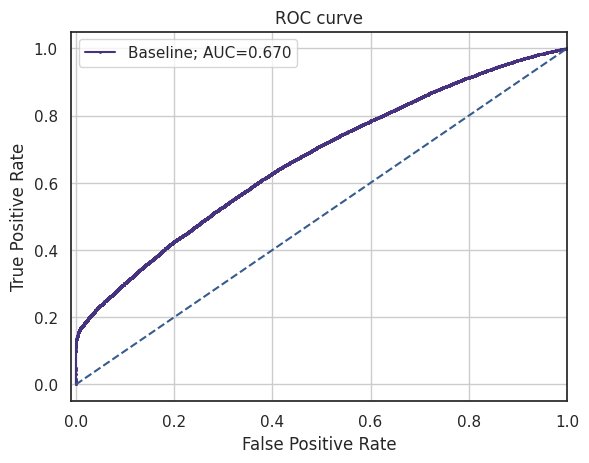

In [13]:
# Setting up ROC Curve plot
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
# Plotting
plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

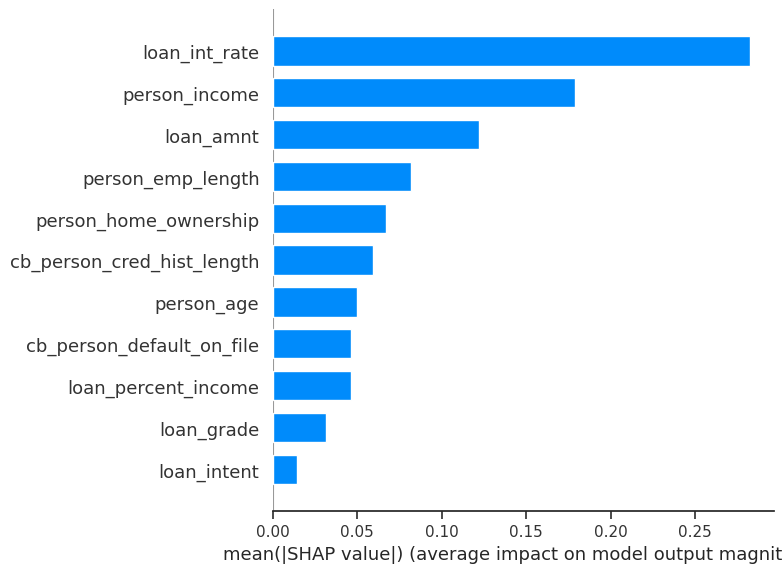

In [14]:
# Defining function to plot feature importance
def plot_importances(model, holdout_data, features):
    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')
    
# Plotting feature importance
plot_importances(model, holdout_data, features)

In [15]:
# Removing 'loan_int_rate' and retraining the model
params2 = dict(params)
params2.update({"ignored_features": ['loan_int_rate']})
model2 = CatBoostClassifier(**params2)
_ = model2.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

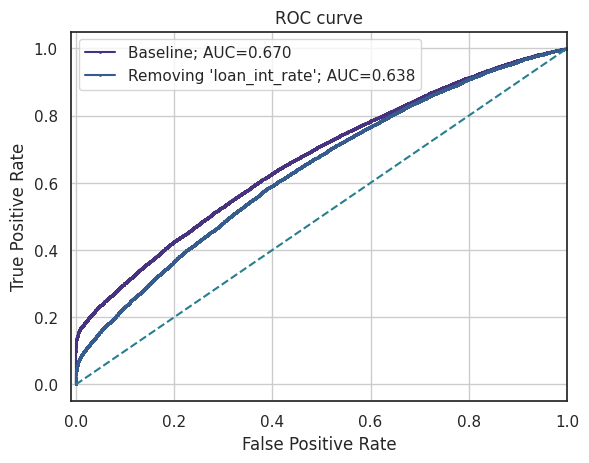

In [16]:
# Plotting updated ROC Curve plot
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model2.predict_proba(holdout_data)[:,1]],
    ['Baseline', "Removing 'loan_int_rate'"]
)

**Conclusion**

Adversarial validation enables us to determine whether or not two datasets (typically training and testing sets) are from the same distribution. In this case, we wanted to determine whether or not the training data provided by Kaggle follows the same distribution as the original data. The first iteration of the Catboost classifier yielded an AUC of ~0.67. While this value represents neither random guess (0.5) or a perfect model (1.0), it provides evidence that the train and original data do not have the exact same distribution. 

By plotting the feature importance of the model, we found that the 'loan_int_rate' feature was the most impactful on the model. This signifies that this feature may be contributing to the difference in distributions between the two datasets. By removing this feature and running the model again, the classifier yielded an AUC of ~0.64. While this value shows a slight improvement (it is approaching 0.5), there is still some evidence that the two datasets do not follow the exact same distribution.

From these results, we can confirm what Kaggle has already stated, i.e. feature distributions in the training data are close to, but not exactly the same, as the original. Because of this, I have opted to not include the original data, as it may negatively impact model performance. 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="5"></a>
# **Exploratory Data Analysis**

<a id="toc"></a>

<a id="5a"></a>
## **Summary Stats**

In [17]:
# Loading back in the Kaggle datasets
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')

In [18]:
# Creating a function to show summary statistics of a given dataset
def show_stats(df):
    stats_df = pd.DataFrame(index = list(df))
    stats_df['Dtype'] = df.dtypes
    stats_df['Count'] = df.count()
    stats_df['#Unique'] = df.nunique()
    stats_df['%Unique'] = stats_df['#Unique'] / len(df) * 100
    stats_df['#Null'] = df.isnull().sum()
    stats_df['%Null'] = stats_df['#Null'] / len(df) * 100
    print(stats_df)

In [19]:
# Examining summary statistics of the training data
show_stats(df_train)

                              Dtype  Count  #Unique   %Unique  #Null  %Null
person_age                    int64  58645       53  0.090374      0    0.0
person_income                 int64  58645     2641  4.503368      0    0.0
person_home_ownership        object  58645        4  0.006821      0    0.0
person_emp_length           float64  58645       36  0.061386      0    0.0
loan_intent                  object  58645        6  0.010231      0    0.0
loan_grade                   object  58645        7  0.011936      0    0.0
loan_amnt                     int64  58645      545  0.929320      0    0.0
loan_int_rate               float64  58645      362  0.617273      0    0.0
loan_percent_income         float64  58645       61  0.104016      0    0.0
cb_person_default_on_file    object  58645        2  0.003410      0    0.0
cb_person_cred_hist_length    int64  58645       29  0.049450      0    0.0
loan_status                   int64  58645        2  0.003410      0    0.0


In [20]:
# Examining summary statistics of the testing data
show_stats(df_test)

                              Dtype  Count  #Unique   %Unique  #Null  %Null
person_age                    int64  39098       52  0.132999      0    0.0
person_income                 int64  39098     2196  5.616656      0    0.0
person_home_ownership        object  39098        4  0.010231      0    0.0
person_emp_length           float64  39098       31  0.079288      0    0.0
loan_intent                  object  39098        6  0.015346      0    0.0
loan_grade                   object  39098        7  0.017904      0    0.0
loan_amnt                     int64  39098      482  1.232800      0    0.0
loan_int_rate               float64  39098      336  0.859379      0    0.0
loan_percent_income         float64  39098       63  0.161134      0    0.0
cb_person_default_on_file    object  39098        2  0.005115      0    0.0
cb_person_cred_hist_length    int64  39098       29  0.074173      0    0.0


<a id="toc"></a>

<a id="5b"></a>
## **Target Variable & Categorical Features**

In [21]:
# Creating 'showplot' function to plot categorical/object features & target variable
def showplot(columnname):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = df_train[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors =["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']
    
    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    # circle
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)
    
    # Count Plot
    sns.countplot(data=df_train, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black',fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9,color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

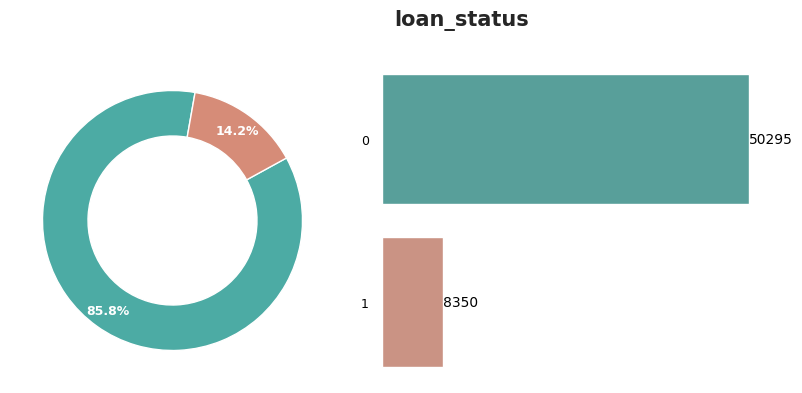

In [22]:
# Visualizing target variable 'loan_status'
showplot('loan_status')

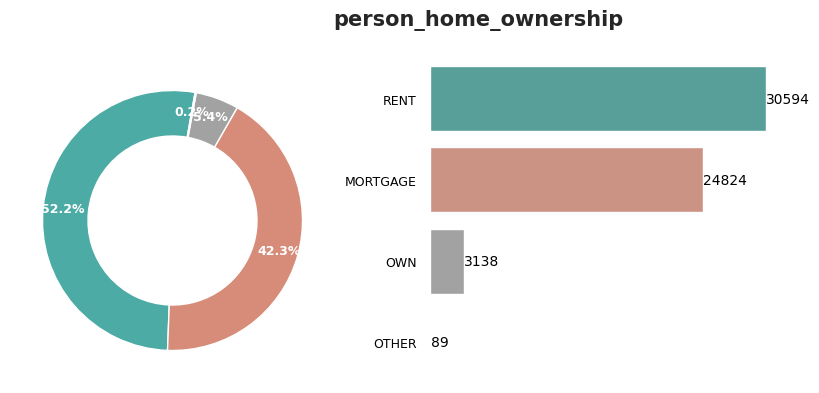

In [23]:
# Visualizing 'person_home_ownership'
showplot('person_home_ownership')

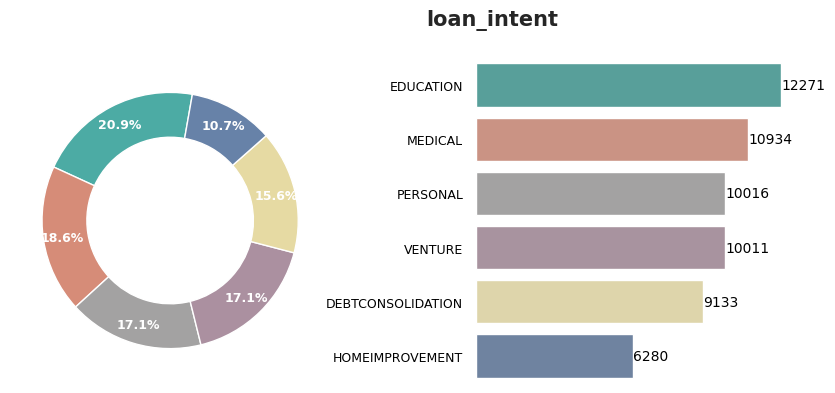

In [24]:
# Visualizing 'loan_intent'
showplot('loan_intent')

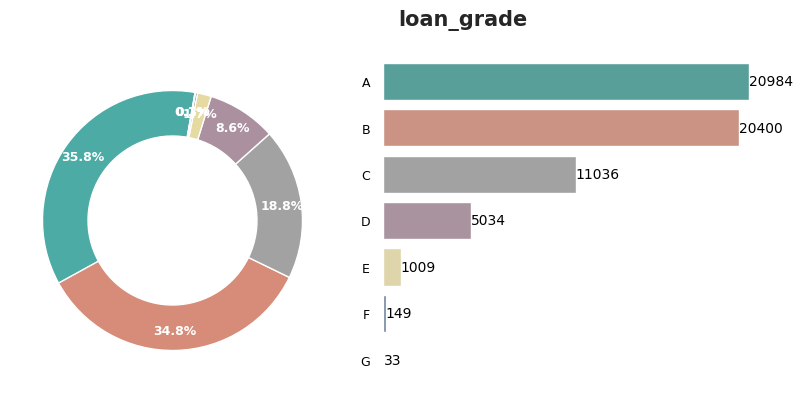

In [25]:
# Visualizing 'loan_grade'
showplot('loan_grade')

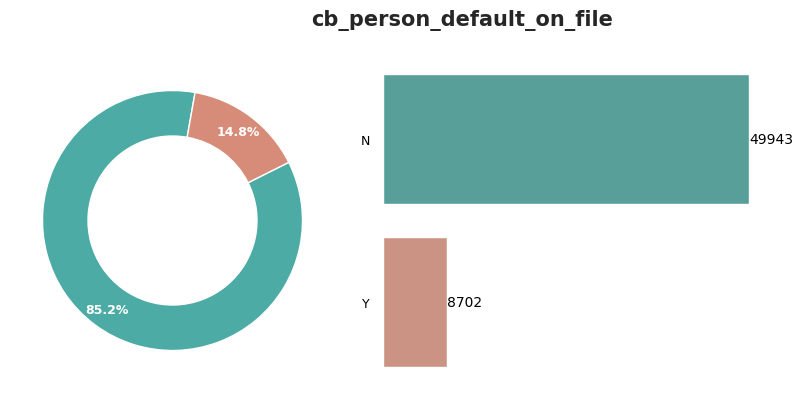

In [26]:
# Visualizing 'cb_person_default_on_file'
showplot('cb_person_default_on_file')

<a id="toc"></a>

<a id="5c"></a>
## **Numerical Features**

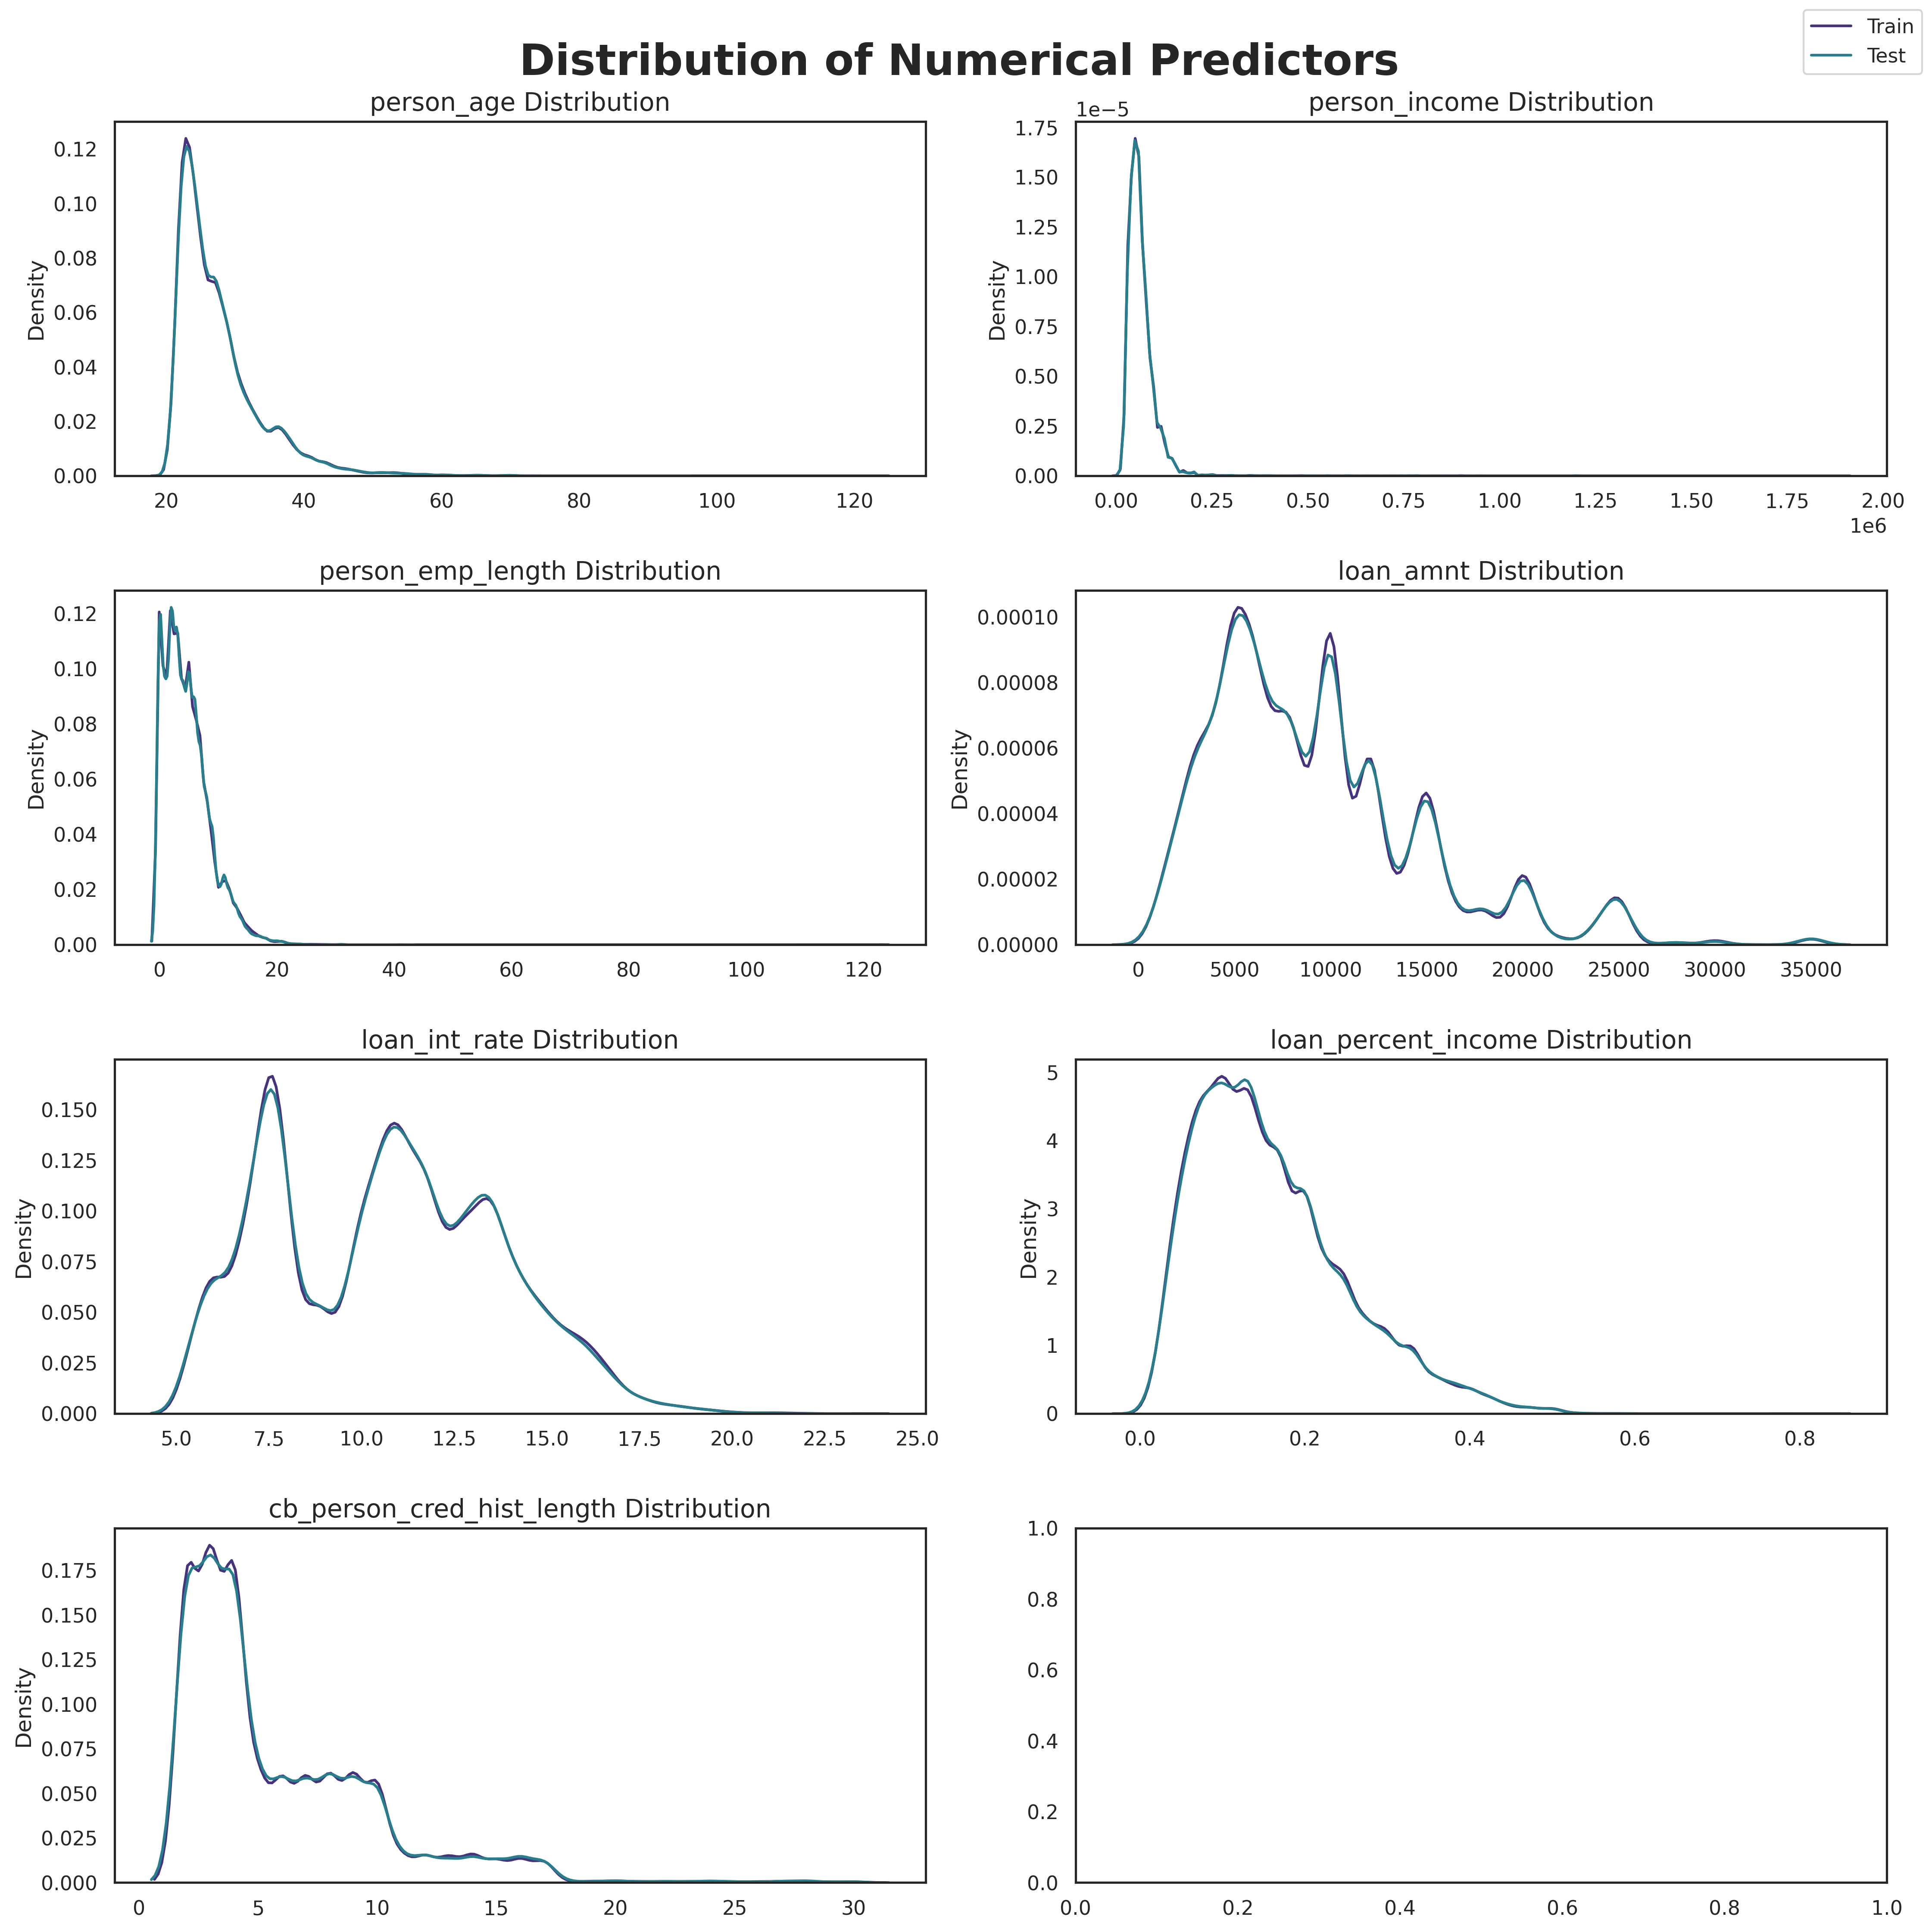

In [27]:
# Visualizing distributions of numerical features
fig, ax = plt.subplots(4, 2, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
train_numerical = df_train.drop(['loan_status', 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], axis=1)
features = train_numerical.columns

for i, column in enumerate(features):
        
    sns.kdeplot(df_train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(df_test[column], ax=ax[i], color=pal[2], warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Predictors', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

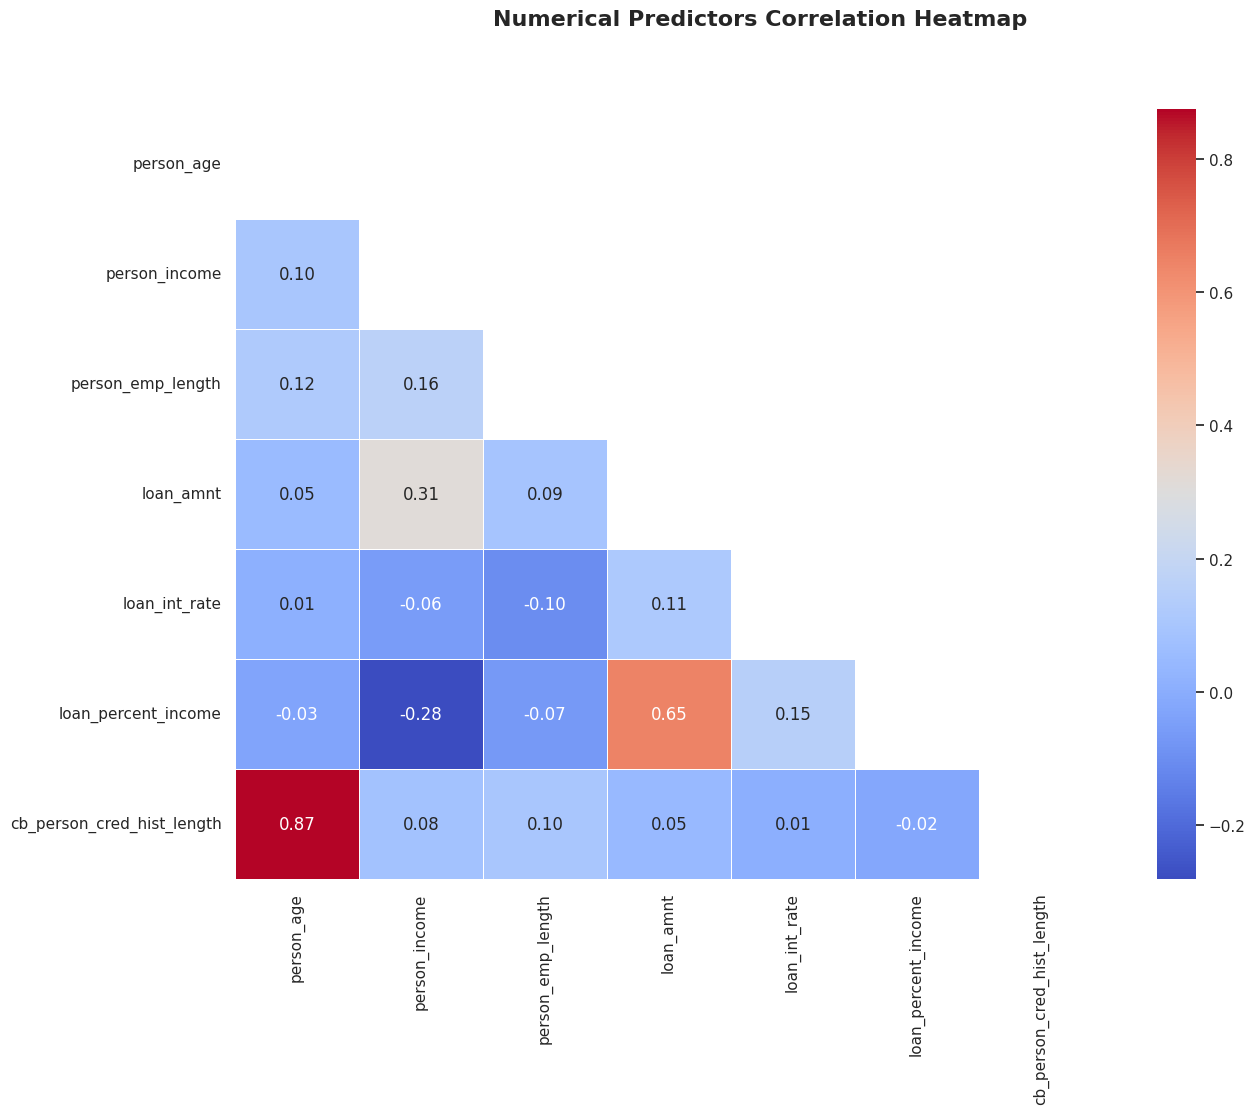

In [28]:
# Plotting correlation heatmap of numerical features
plt.figure(figsize=(14,10))
corr=train_numerical.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.suptitle('Numerical Predictors Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

<a id="toc"></a>

<a id="5d"></a>
## **Sweetviz**

                                             |          | [  0%]   00:00 -> (? left)


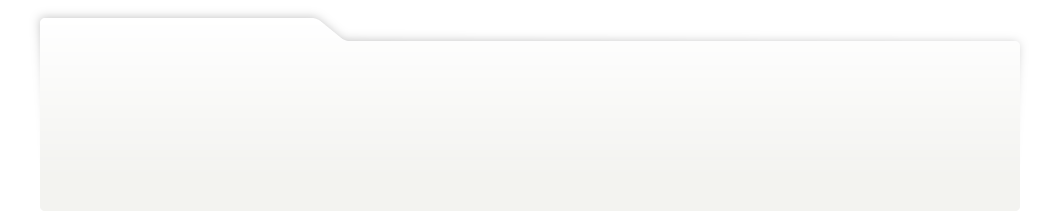
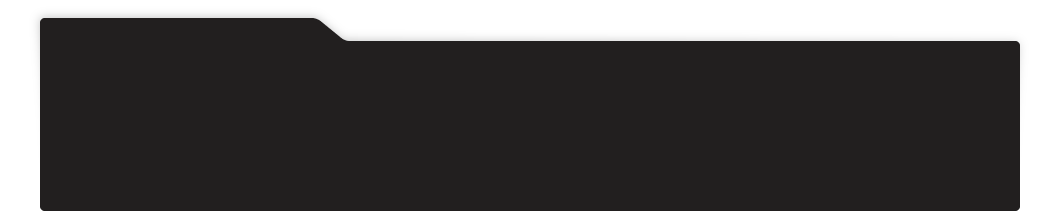
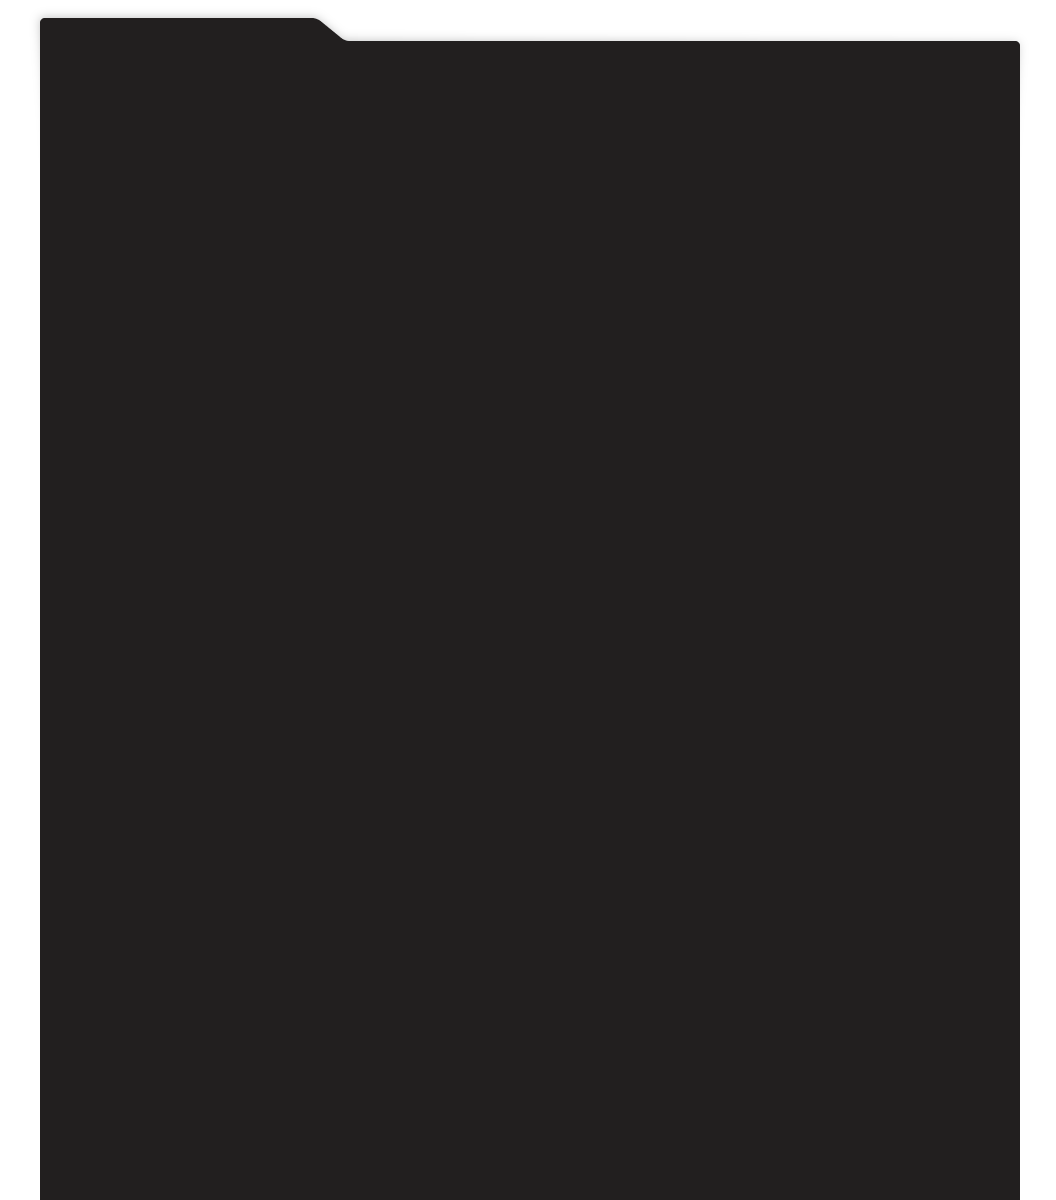
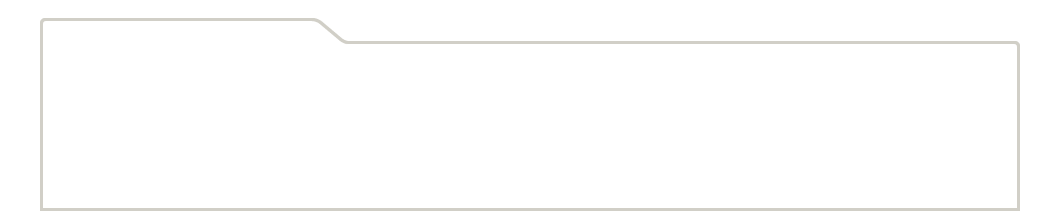
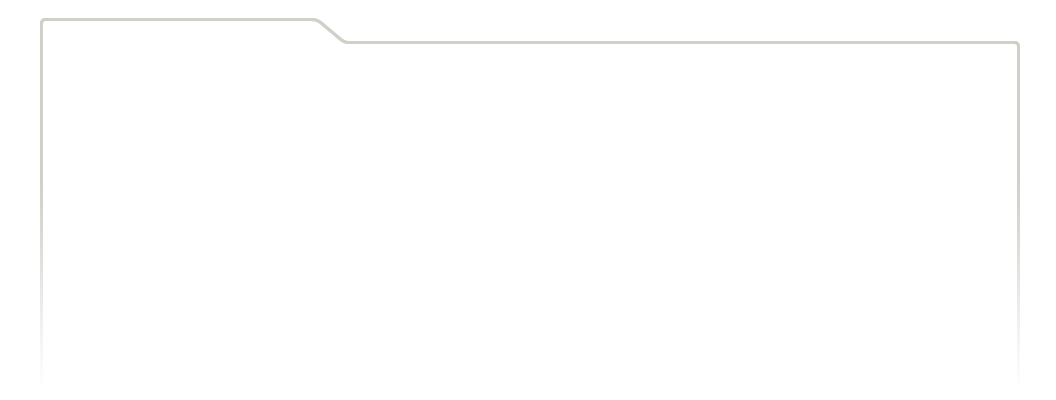
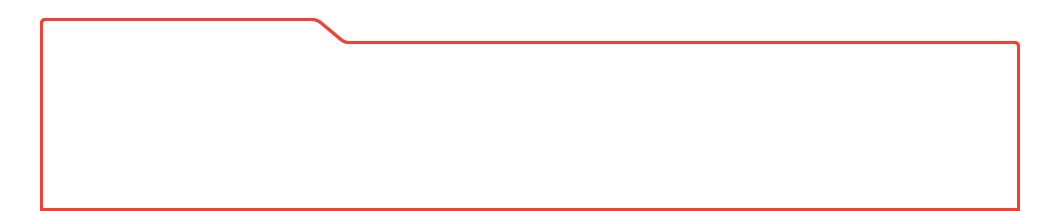
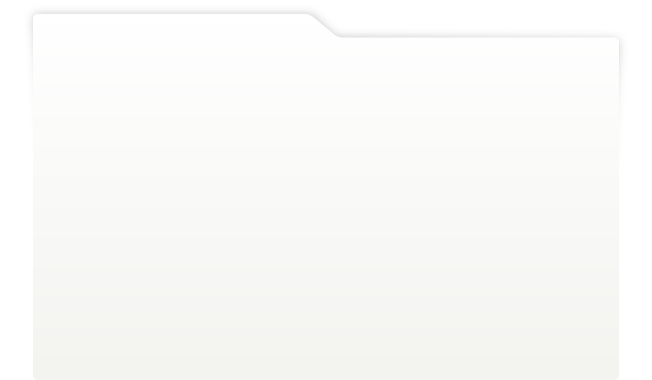
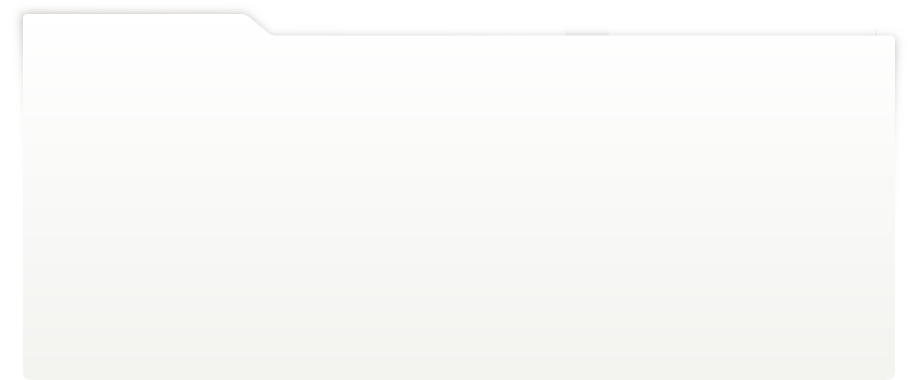
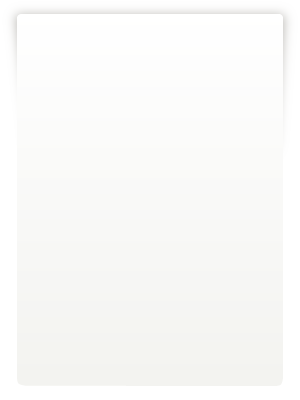
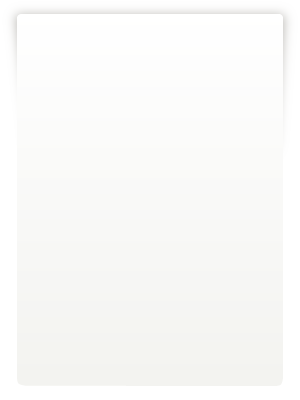
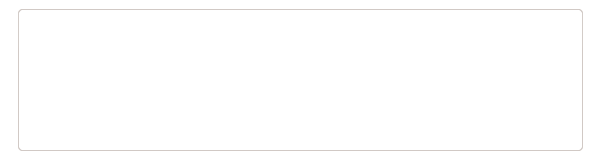
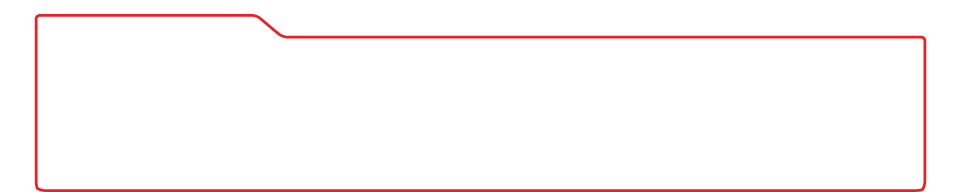
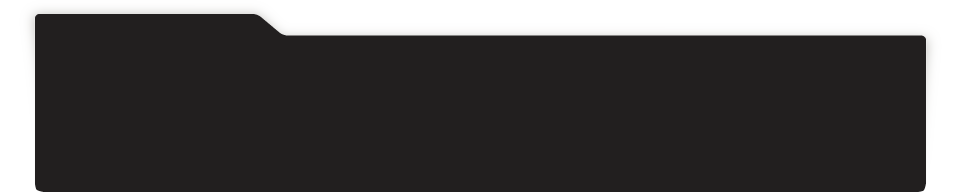
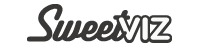
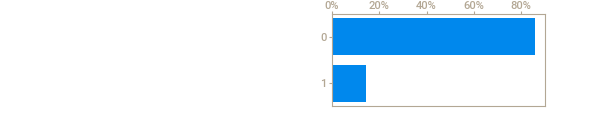
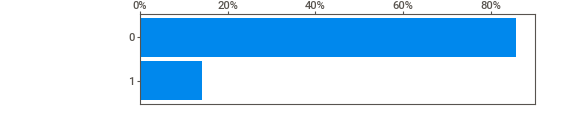
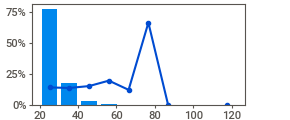
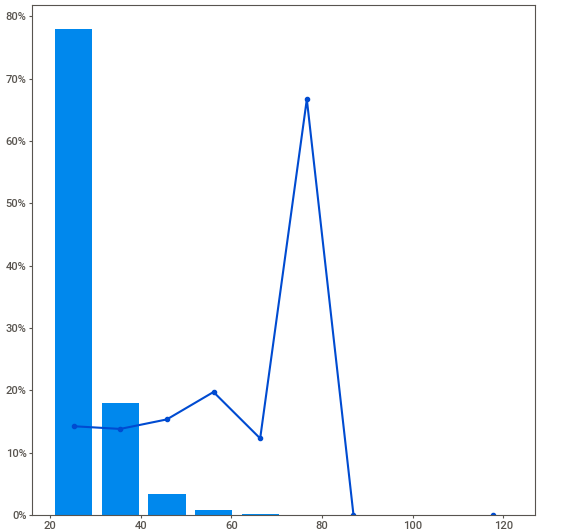
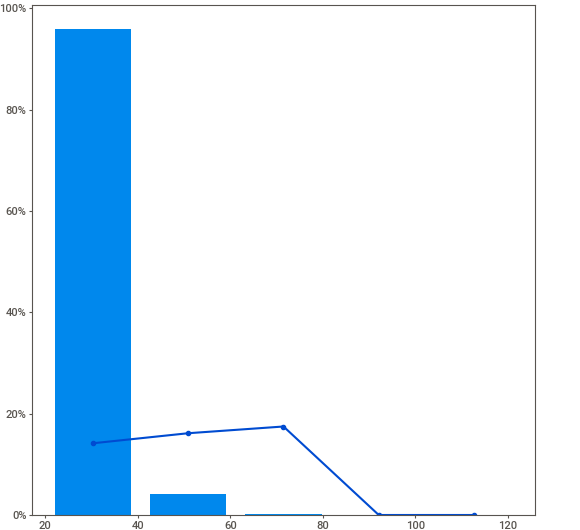
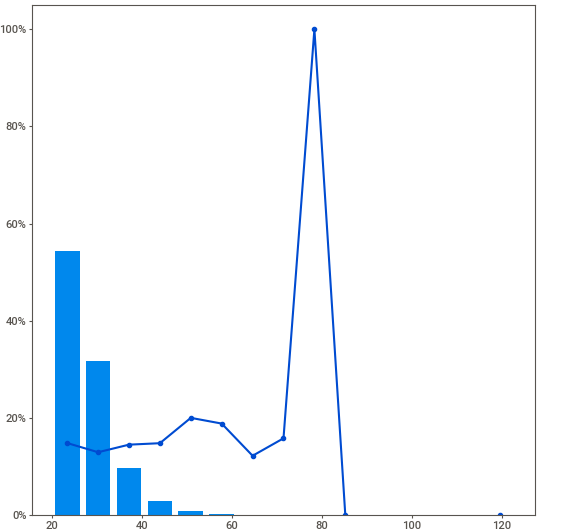
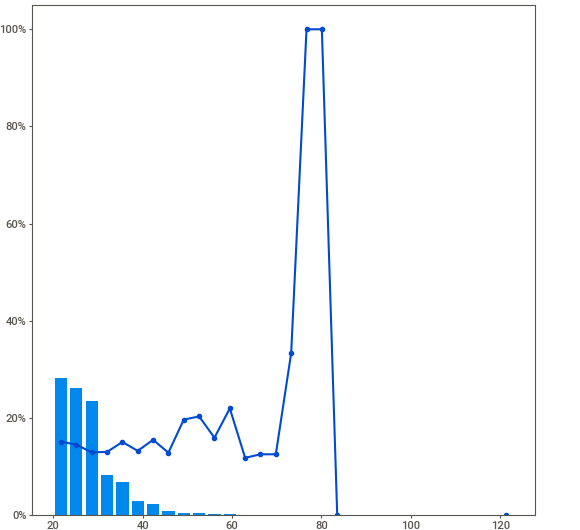
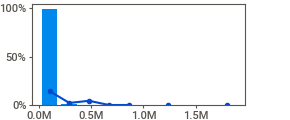
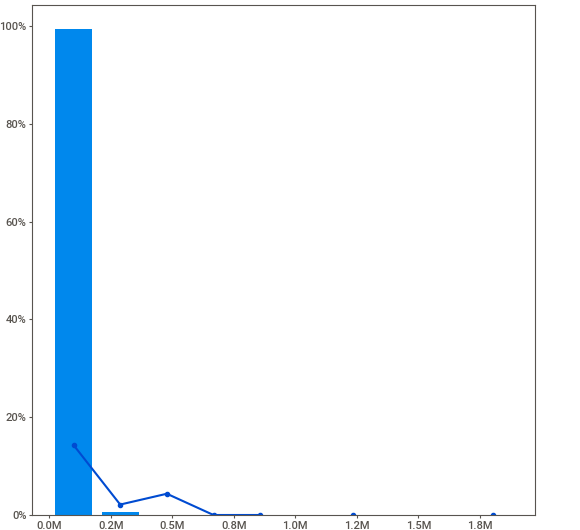
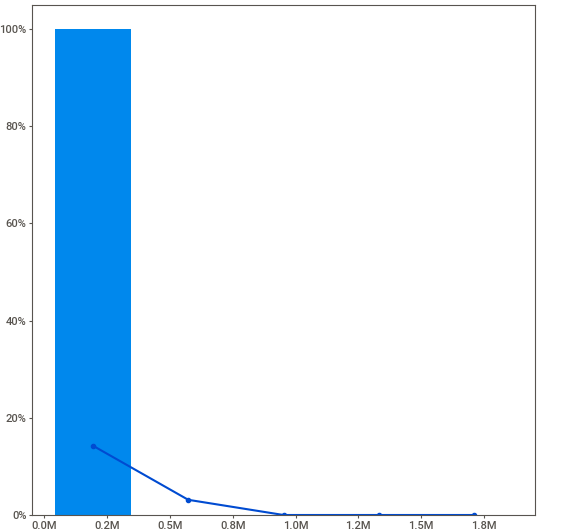
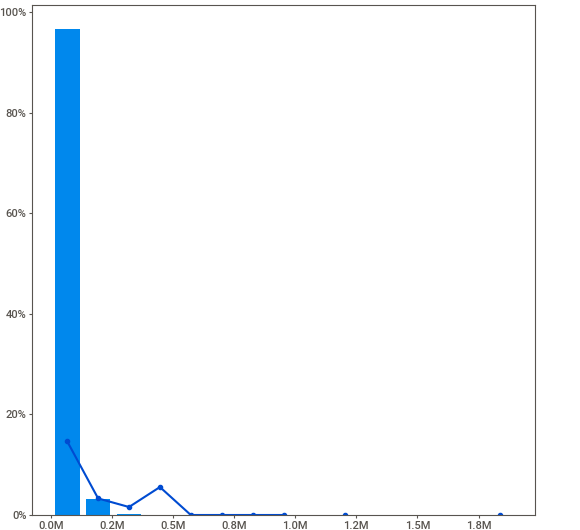
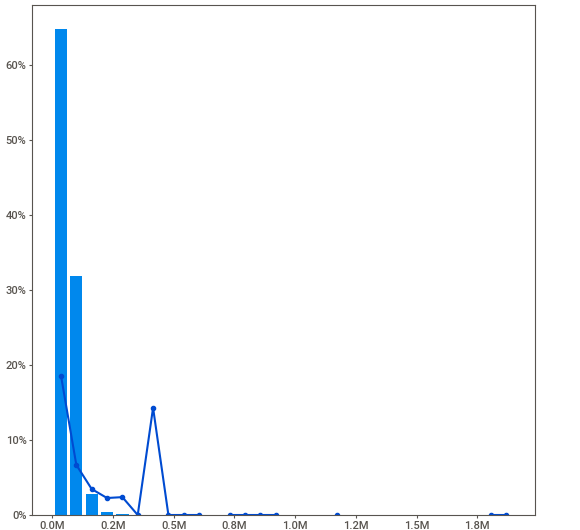
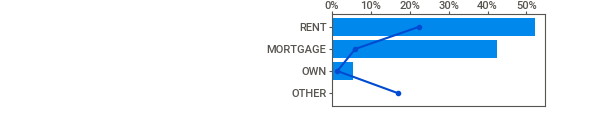
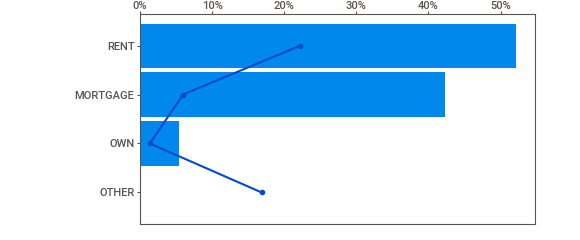
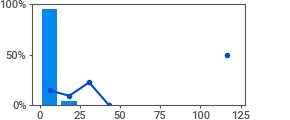
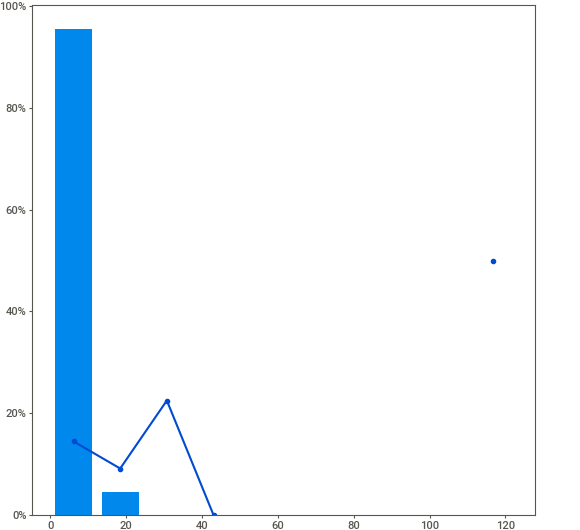
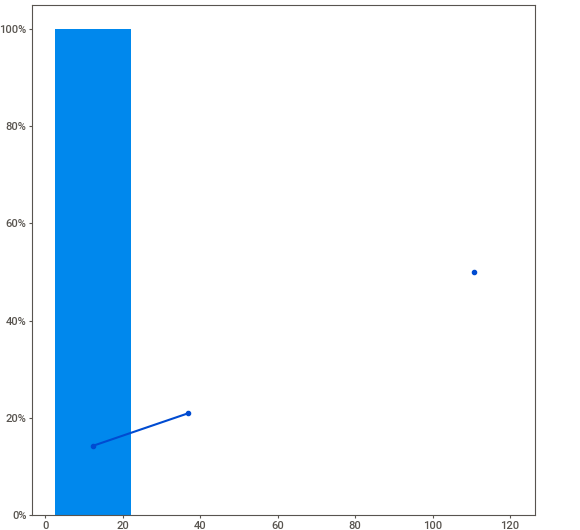
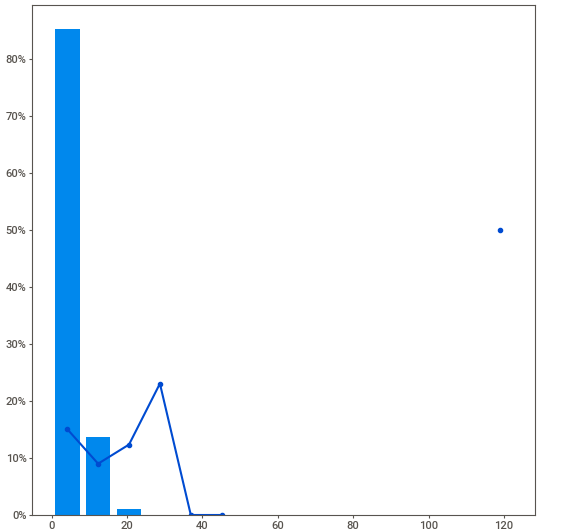
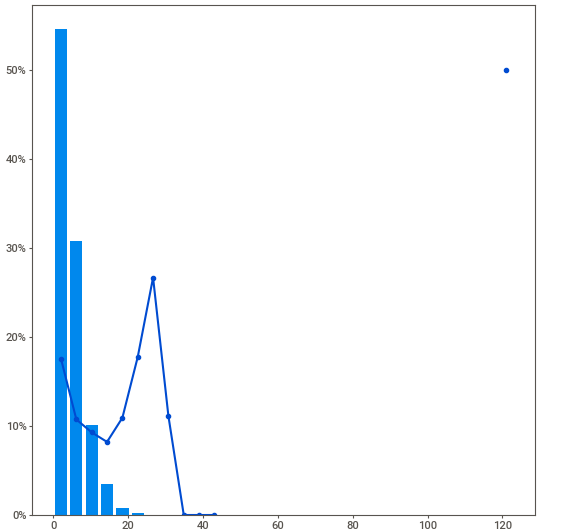
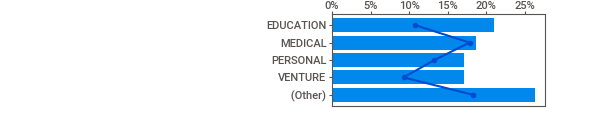
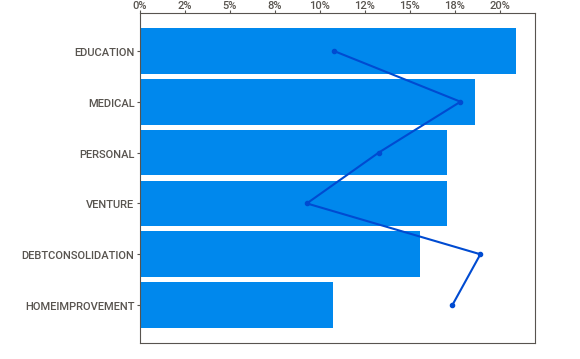
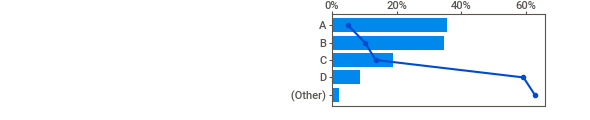
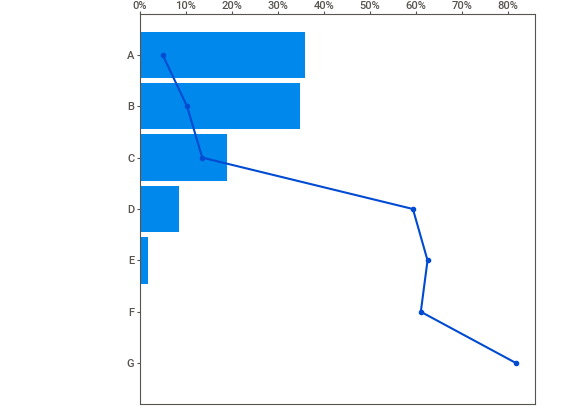
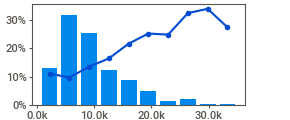
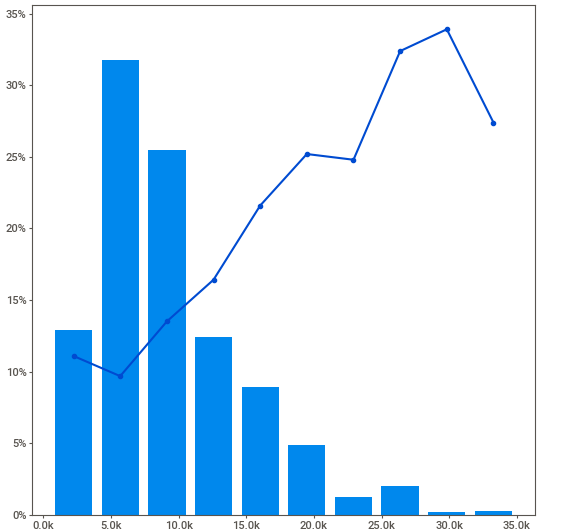
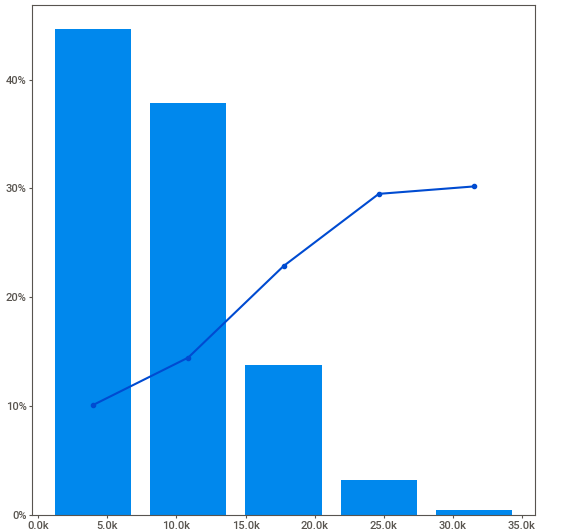
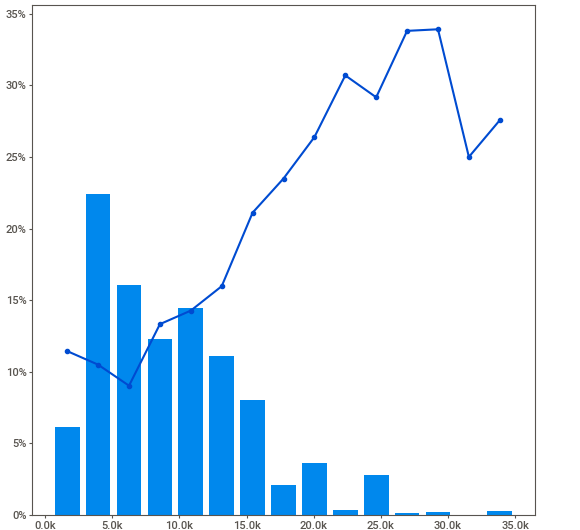
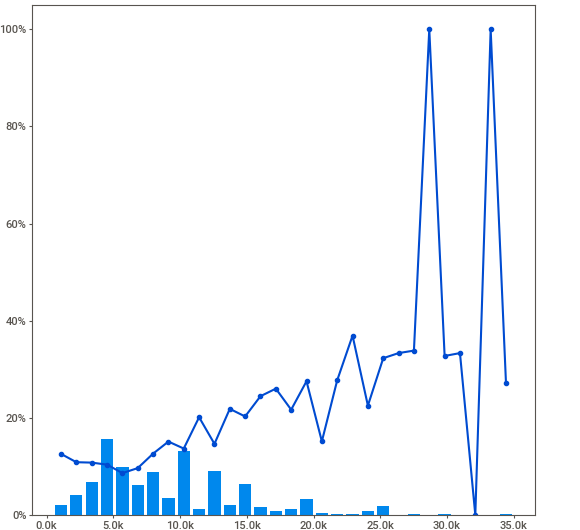
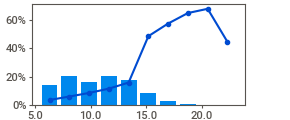
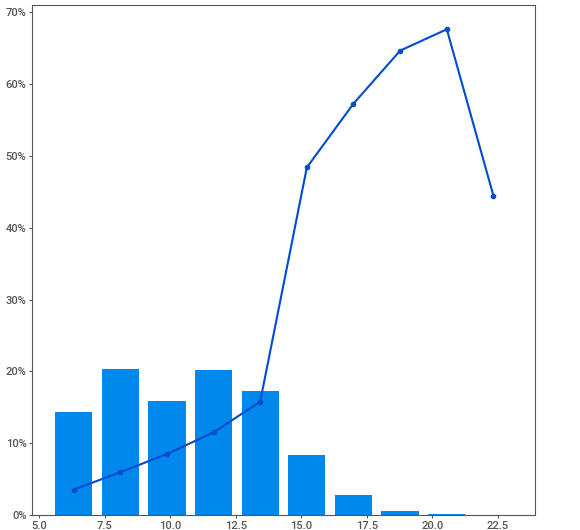
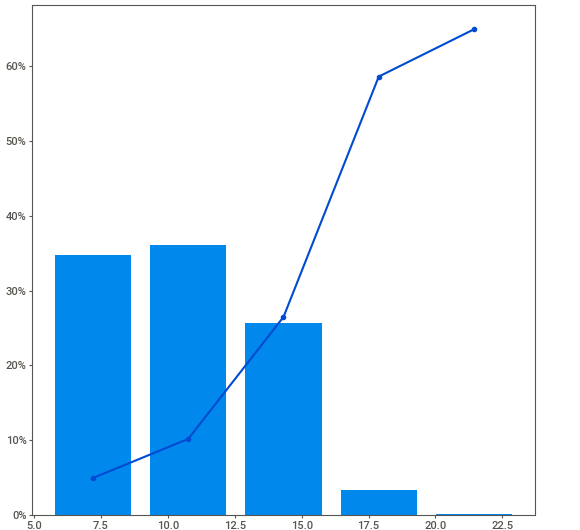
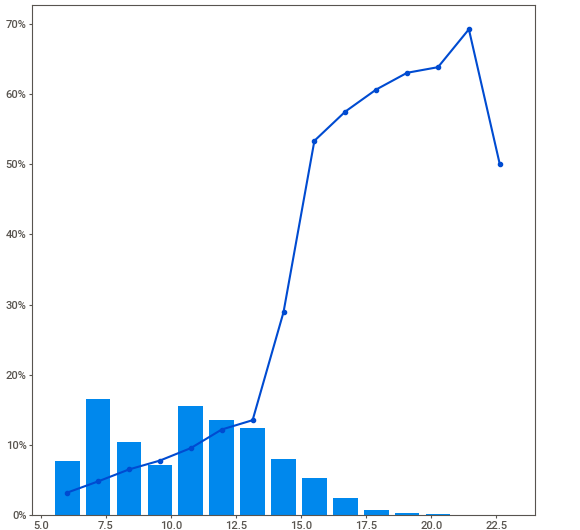
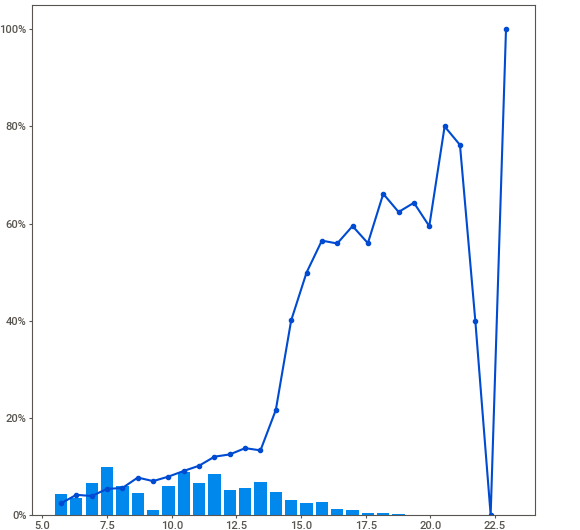
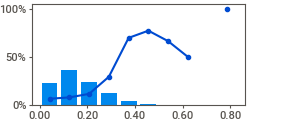
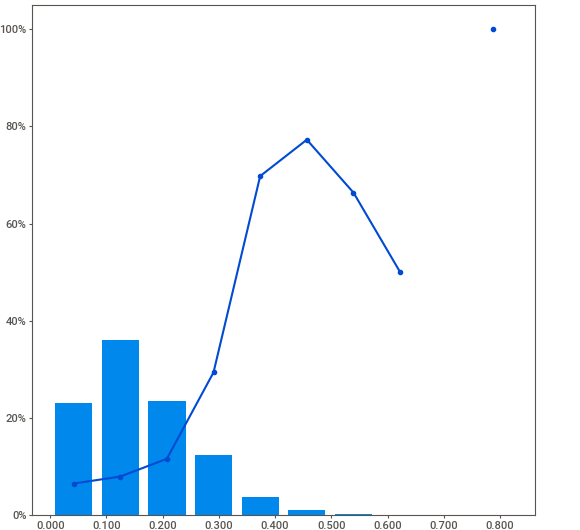
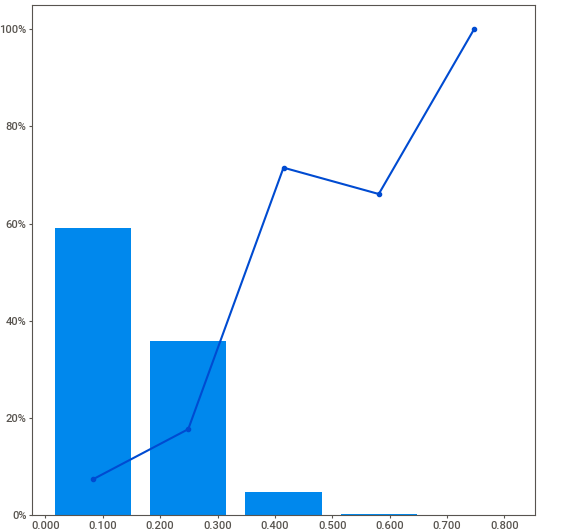
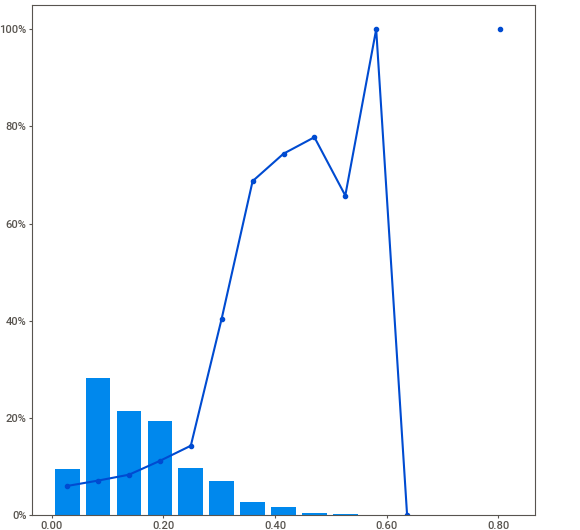
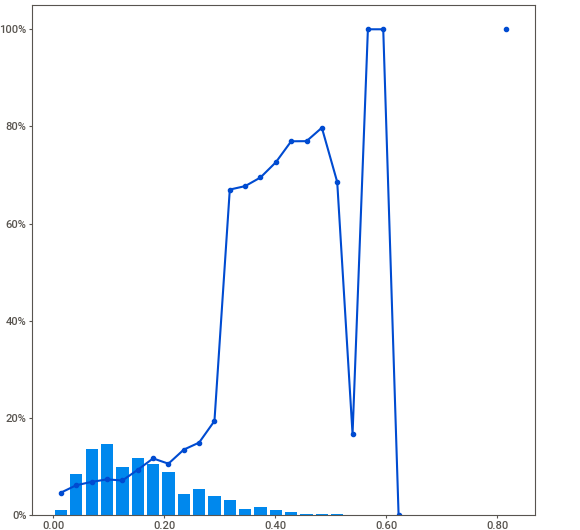
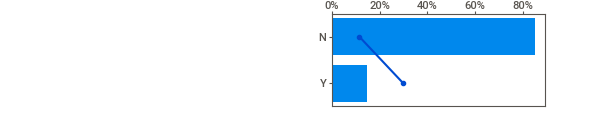
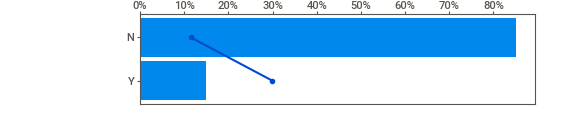
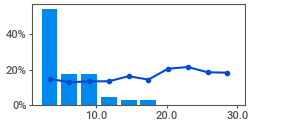
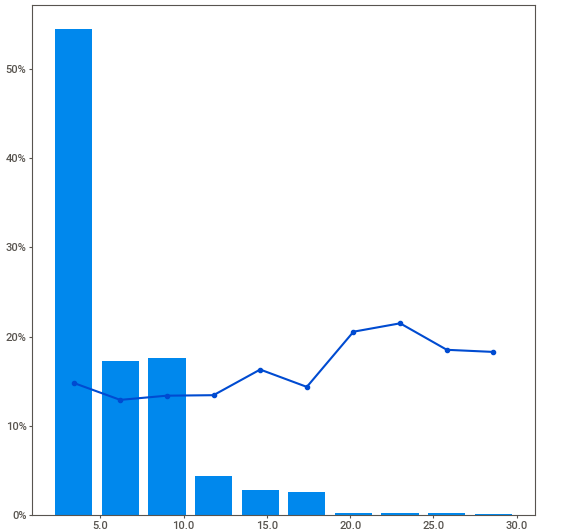
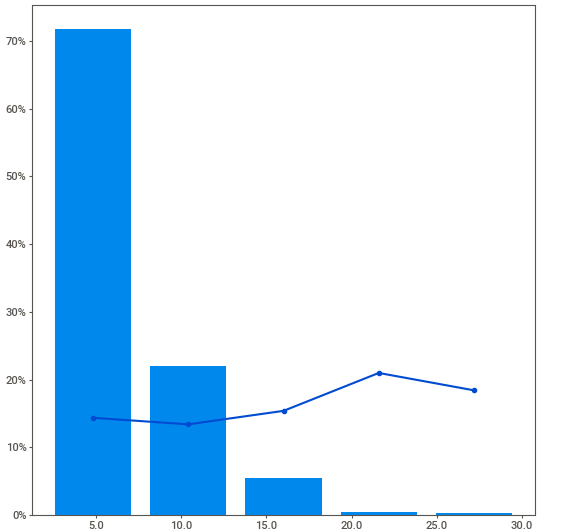
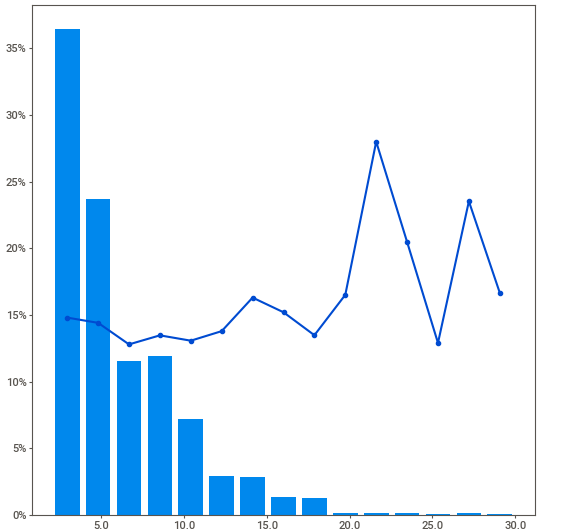
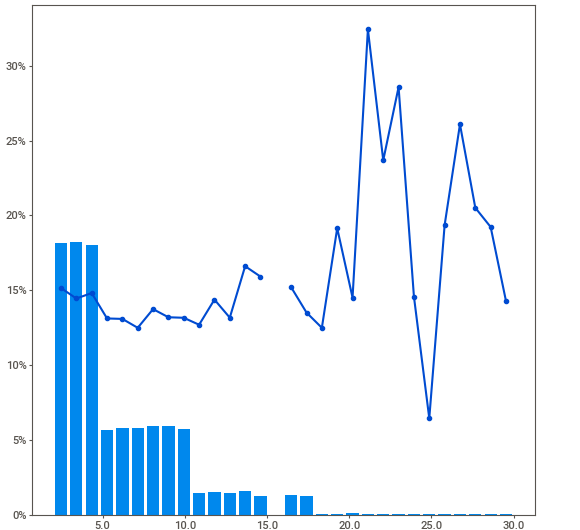
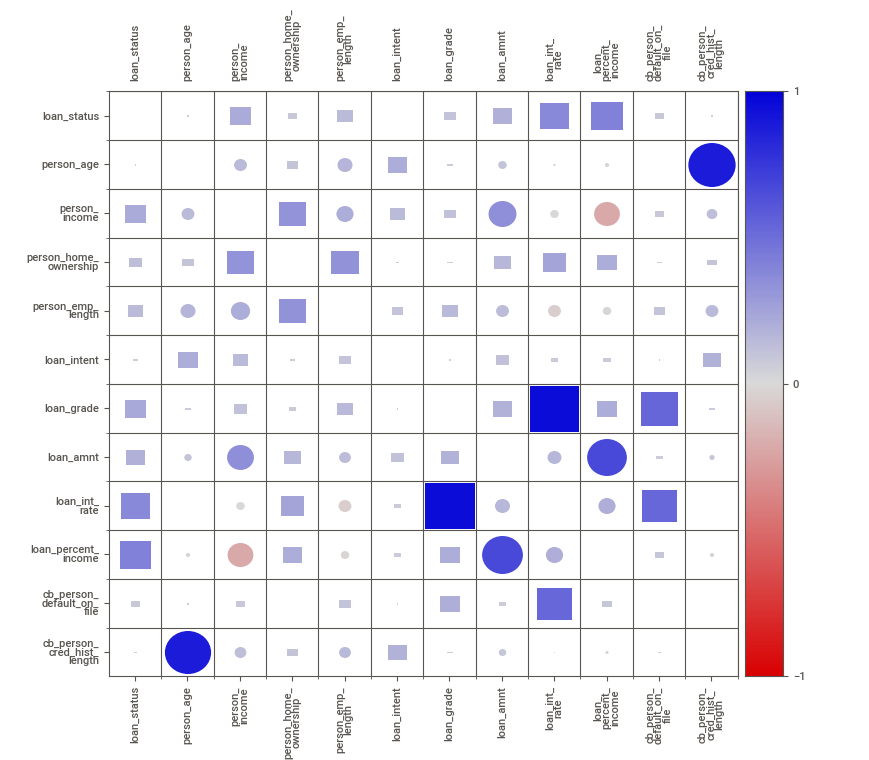
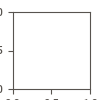

In [29]:
# Using Sweetviz to automate the EDA of the training dataset
sv_train = sv.analyze(df_train, target_feat = 'loan_status')
sv_train.show_notebook(w='100%', h='full')

                                             |          | [  0%]   00:00 -> (? left)


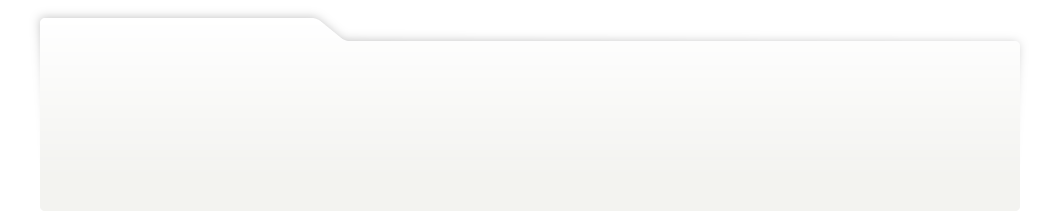
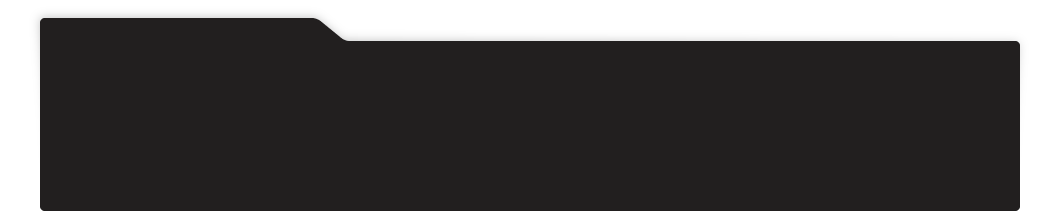
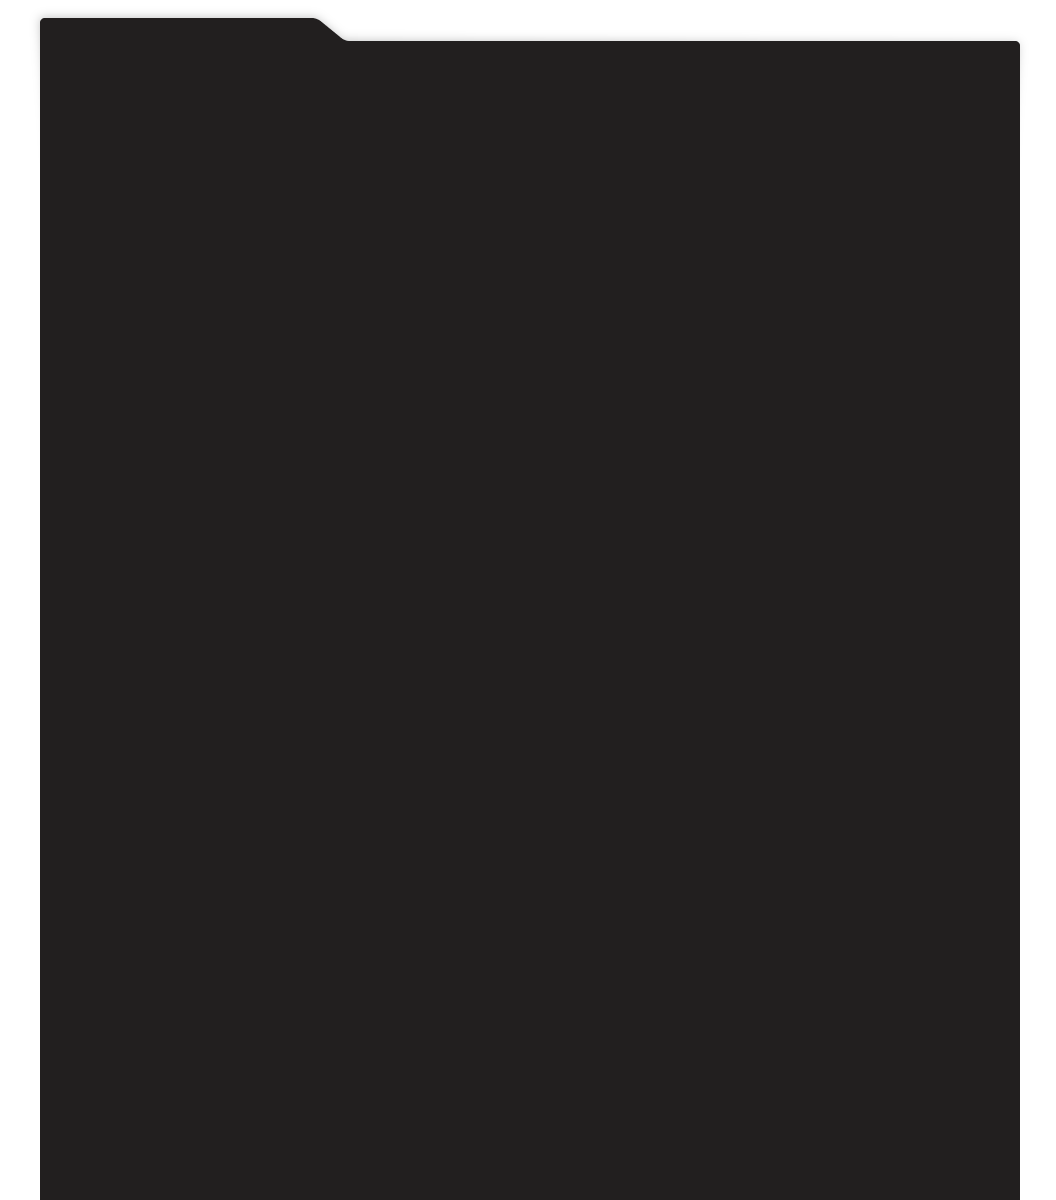
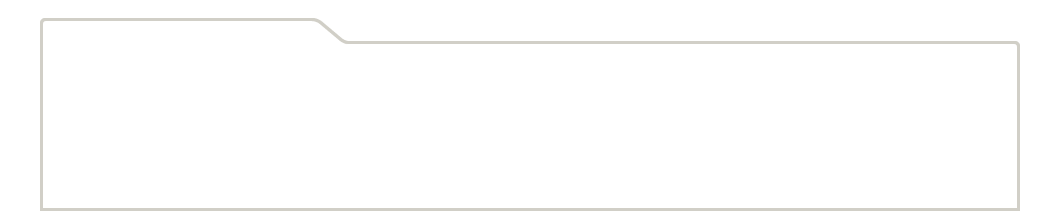
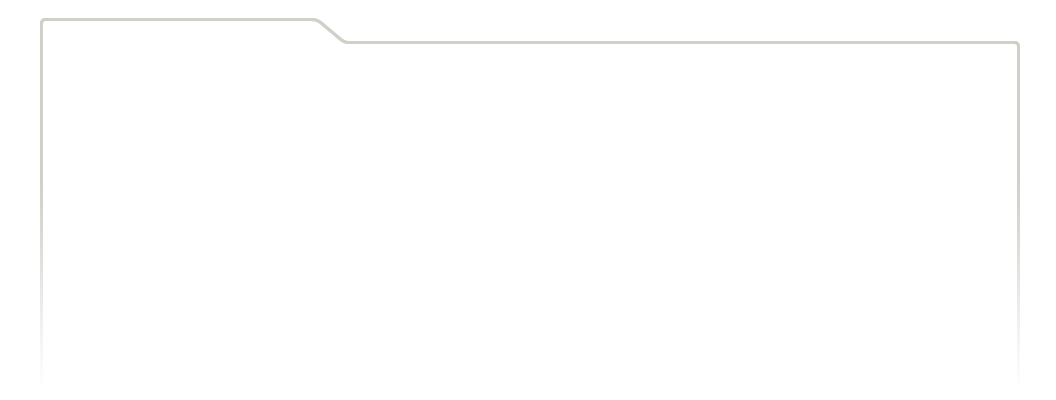
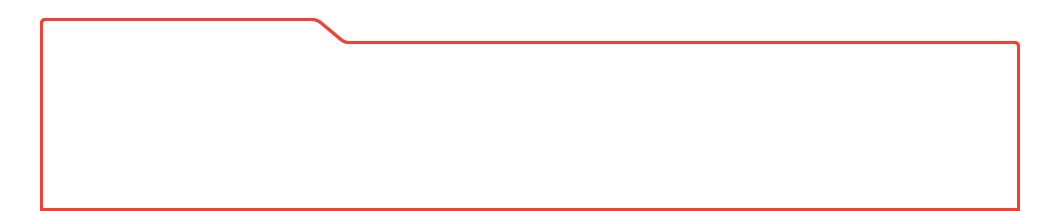
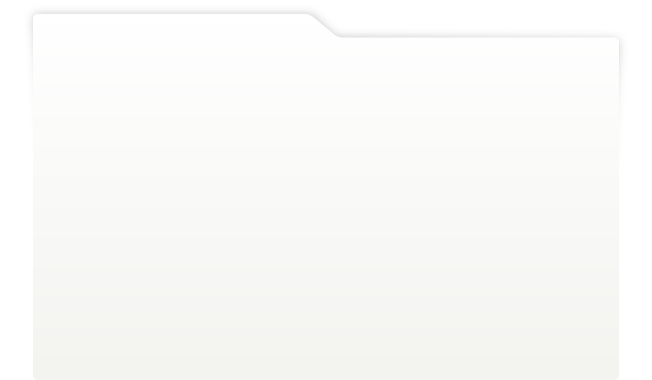
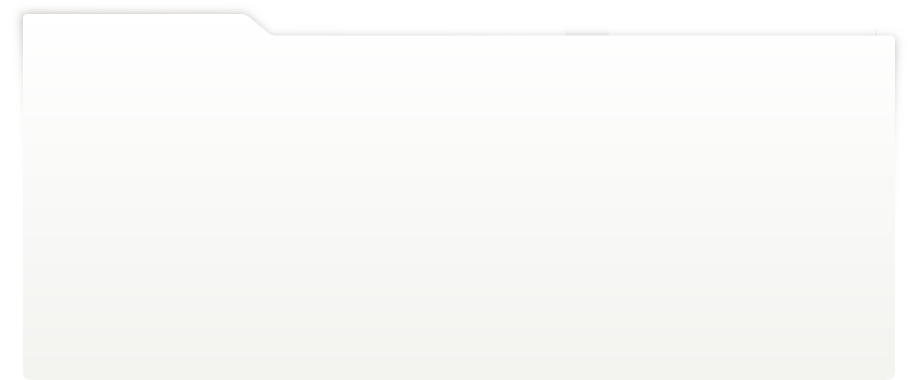
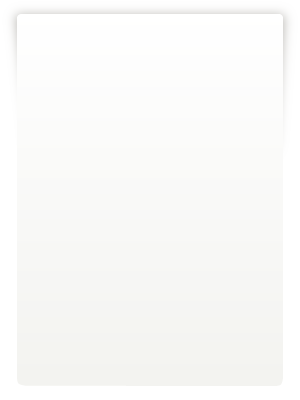
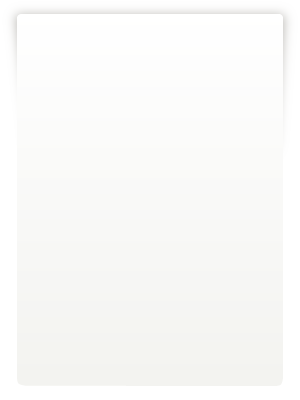
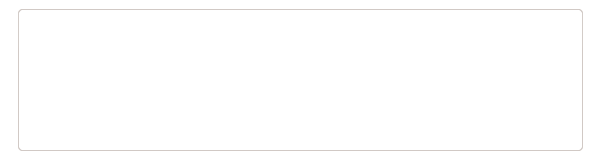
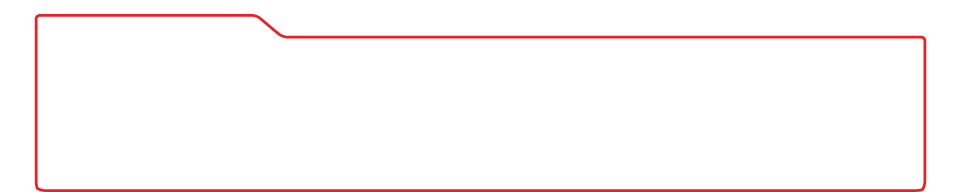
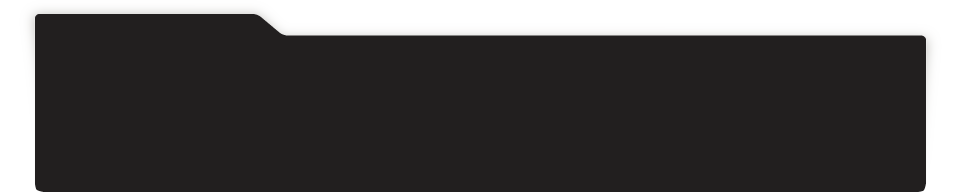
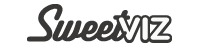
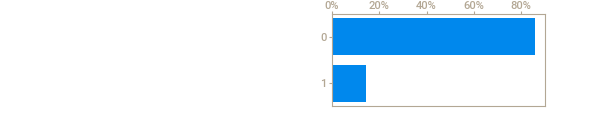
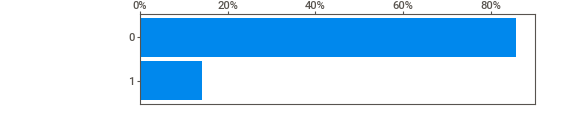
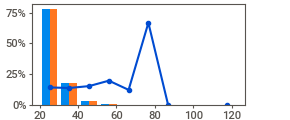
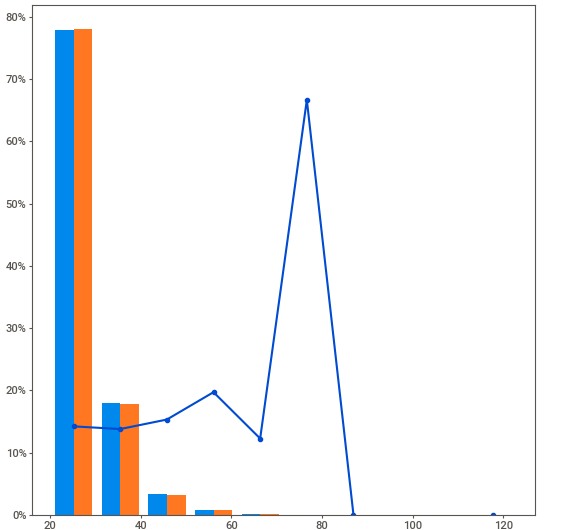
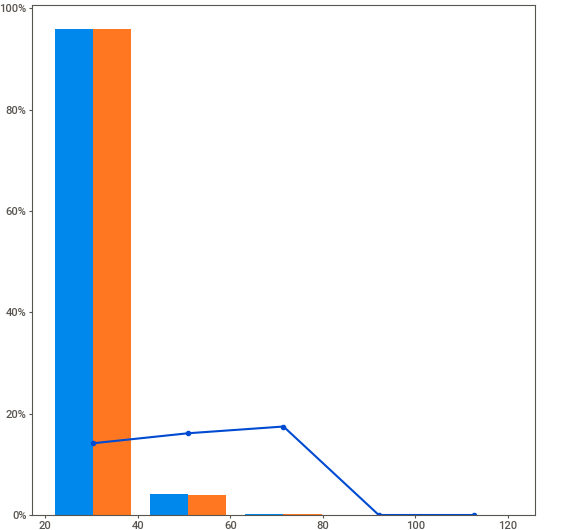
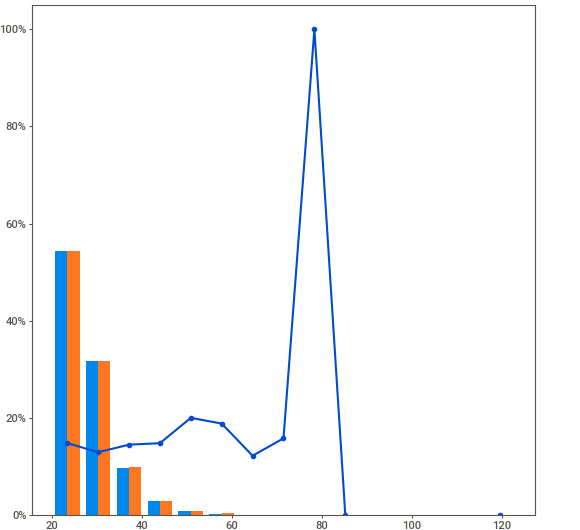
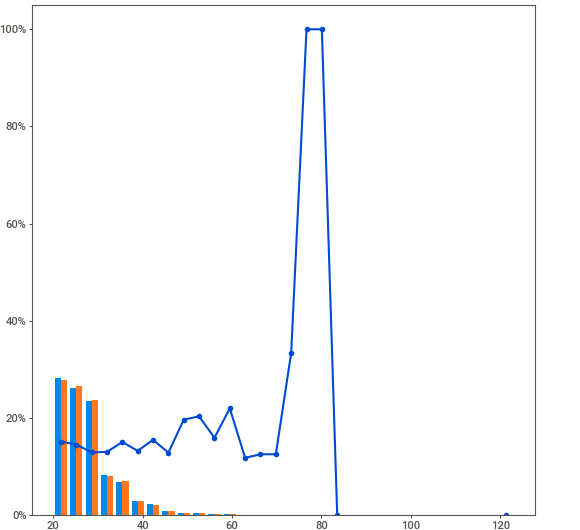
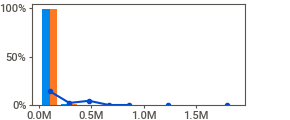
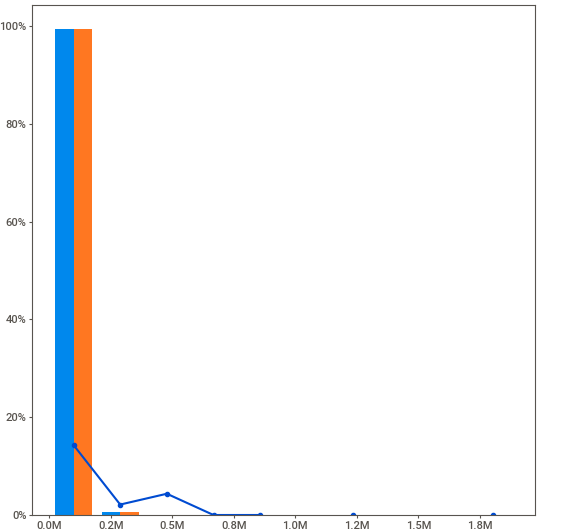
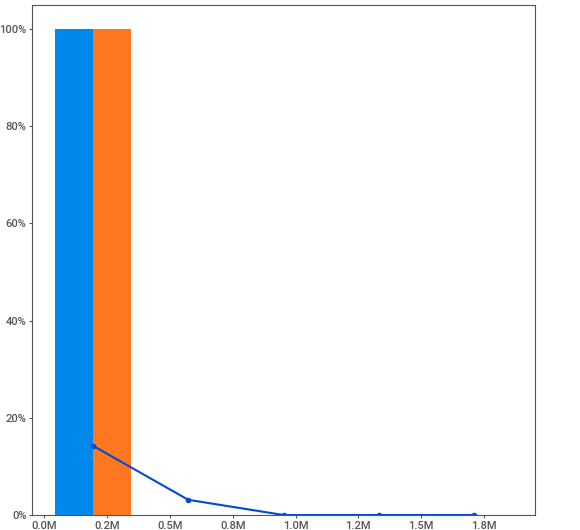
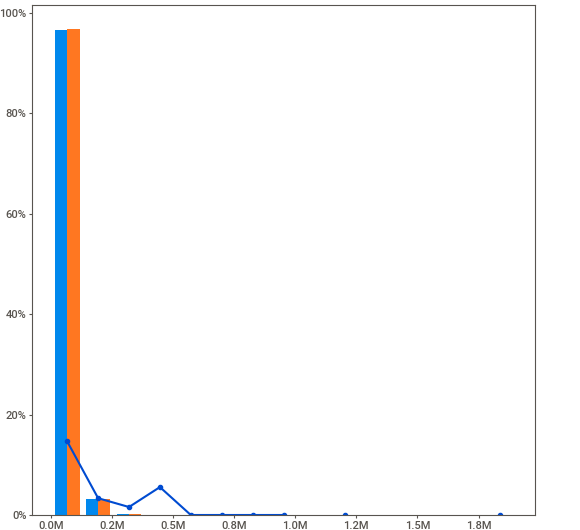
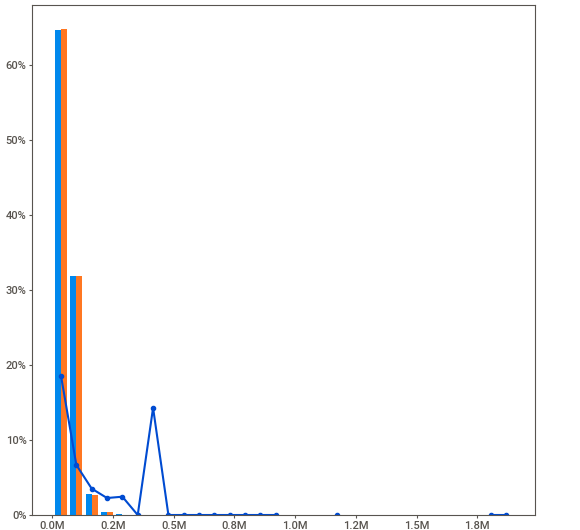
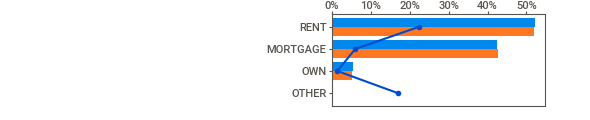
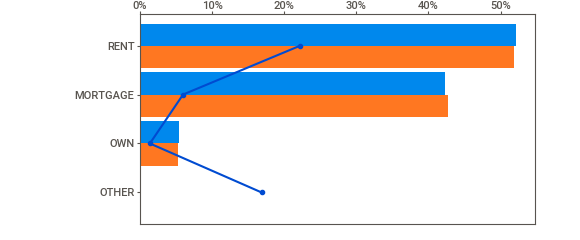
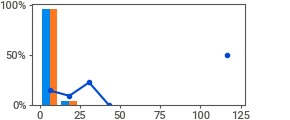
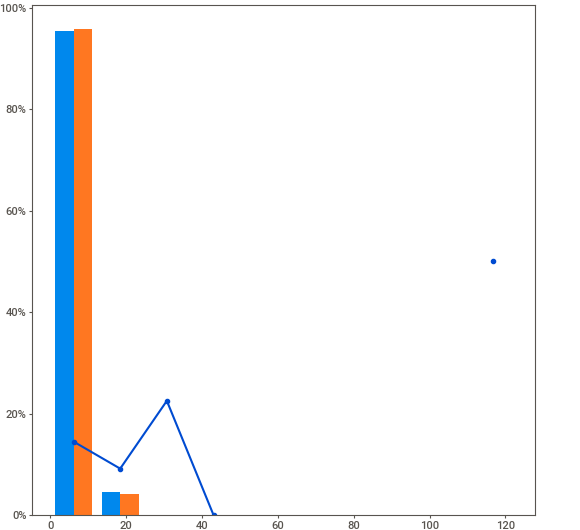
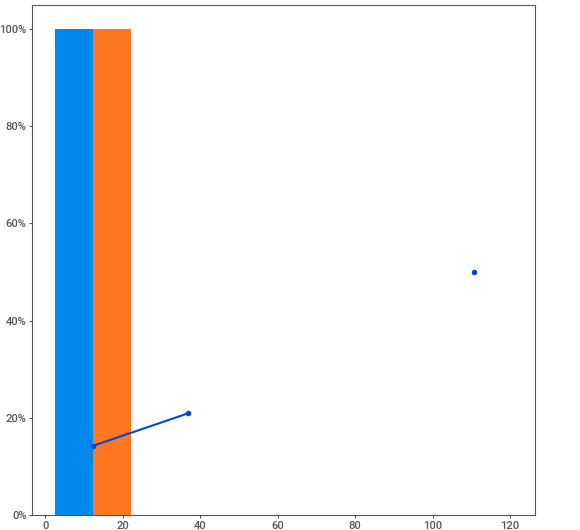
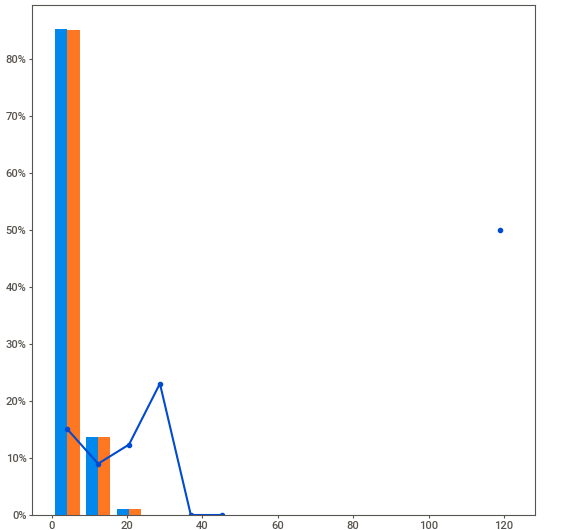
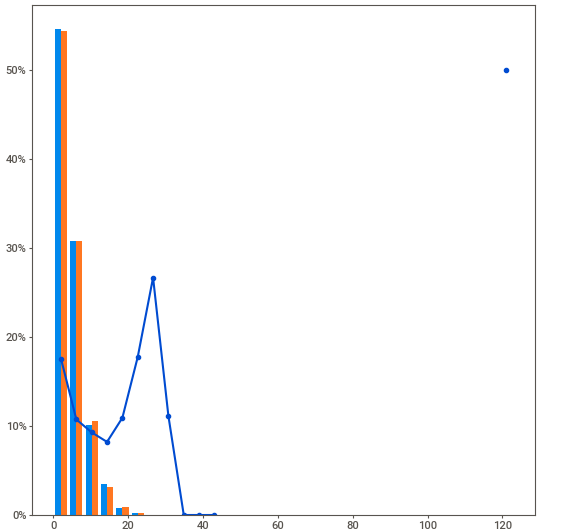
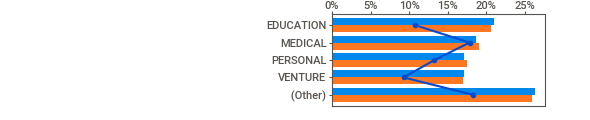
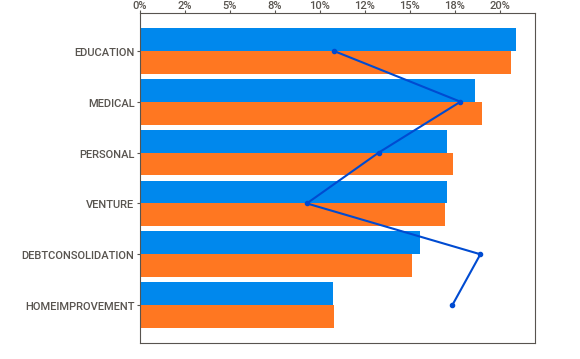
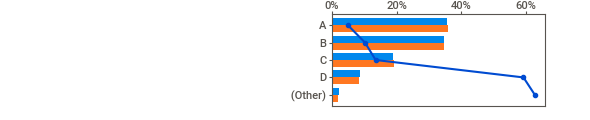
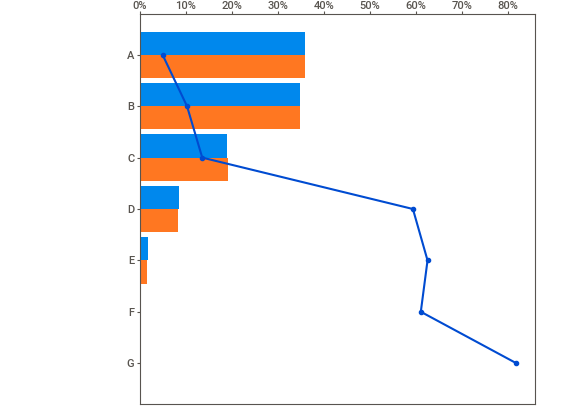
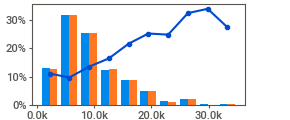
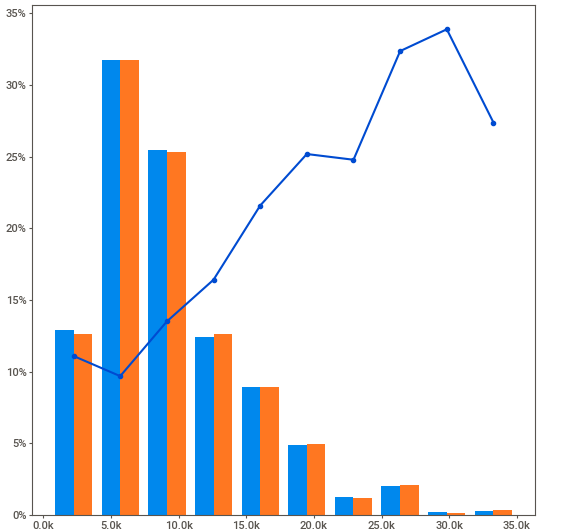
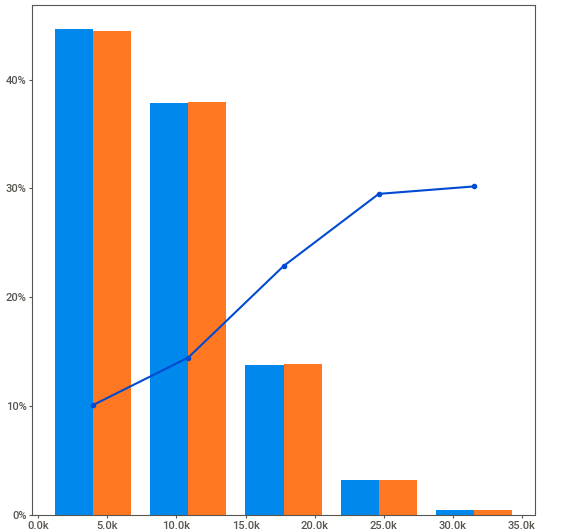
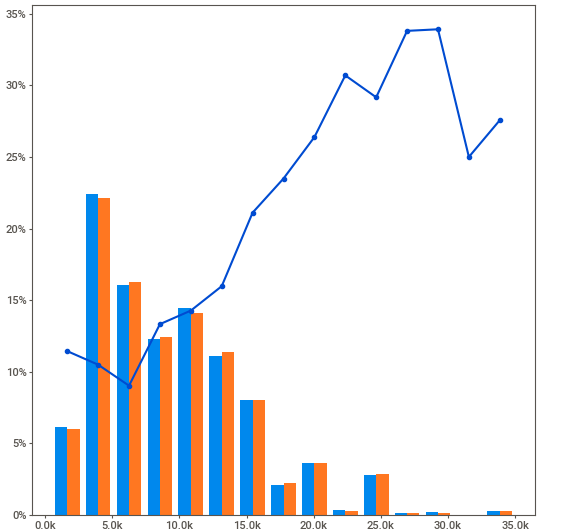
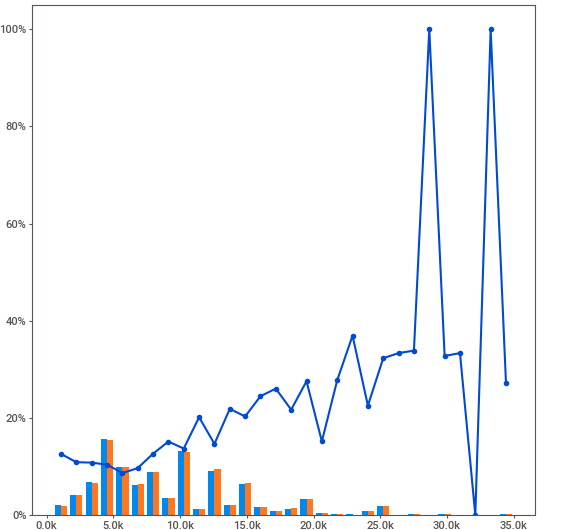
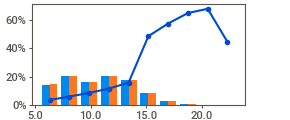
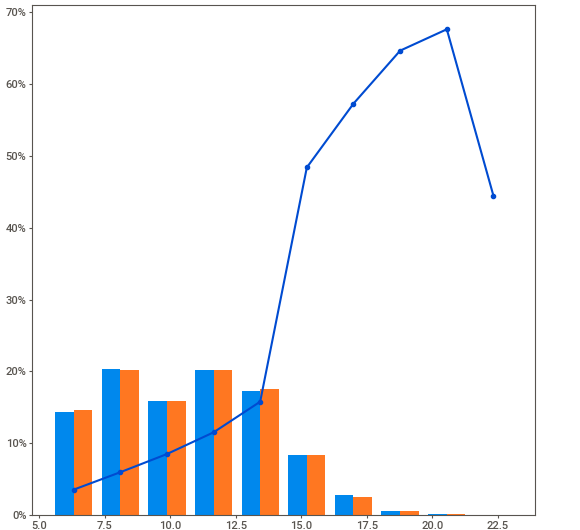
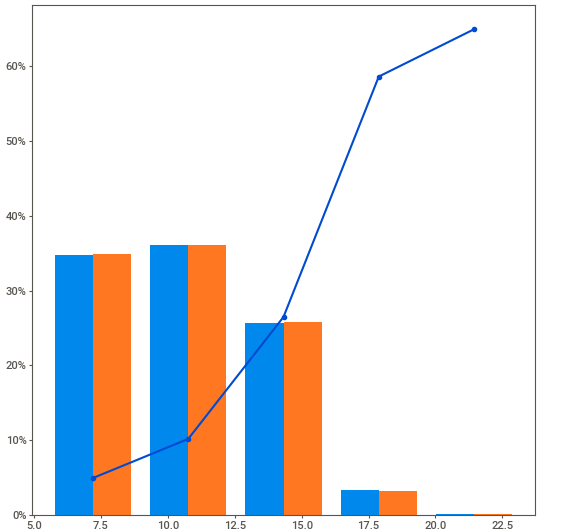
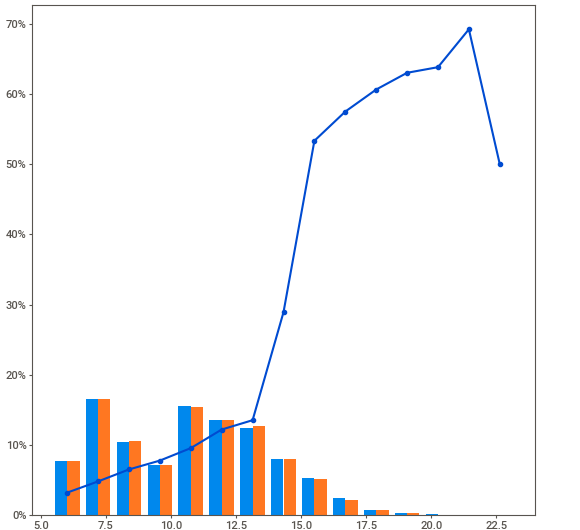
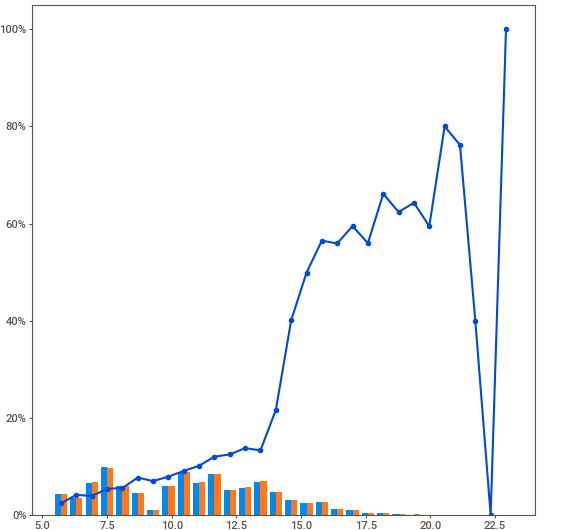
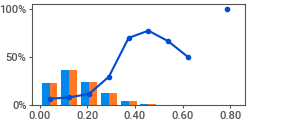
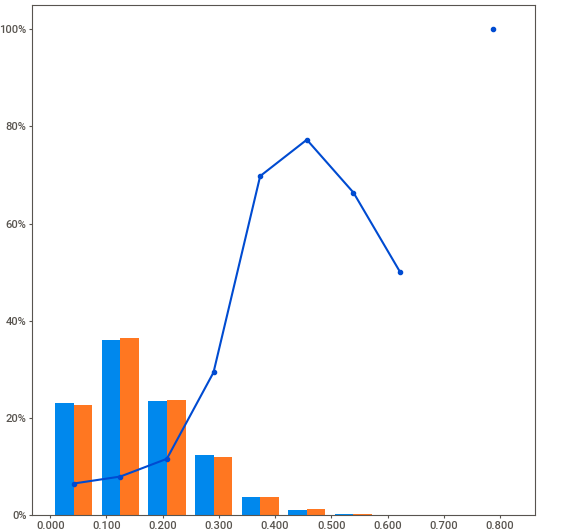
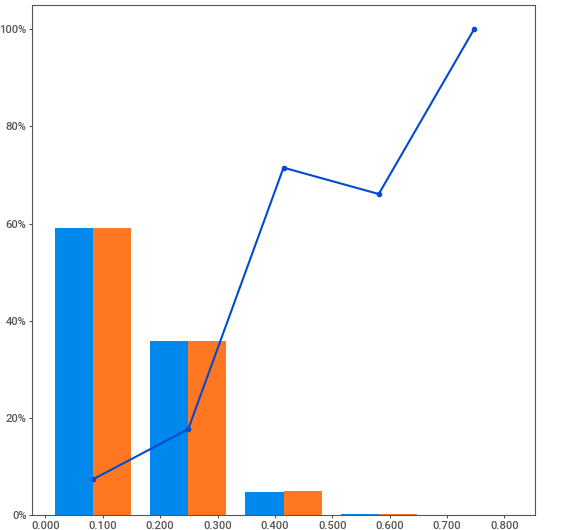
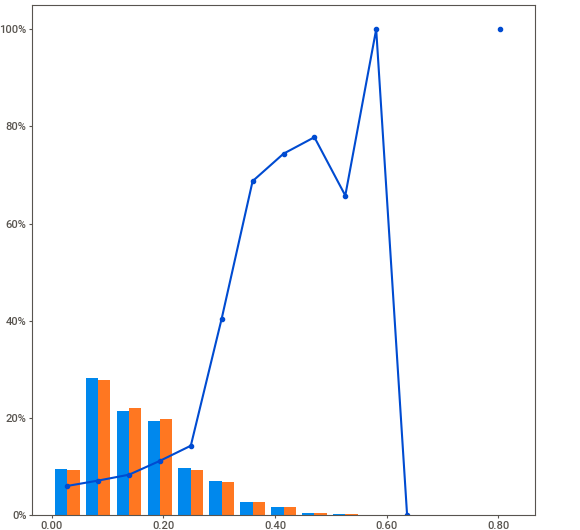
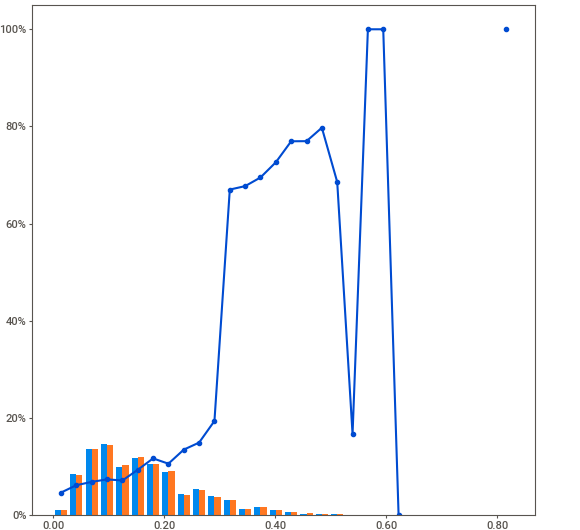
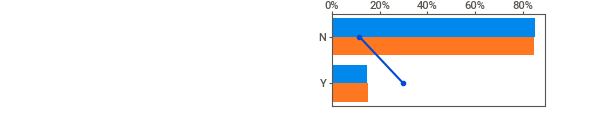
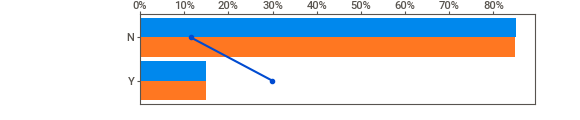
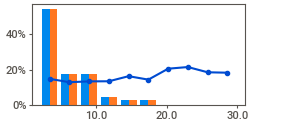
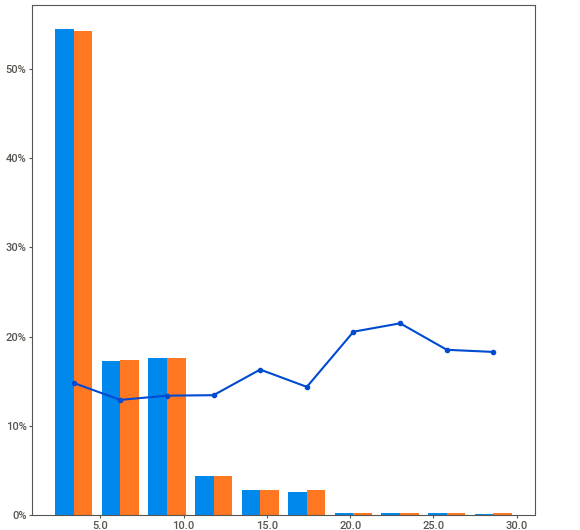
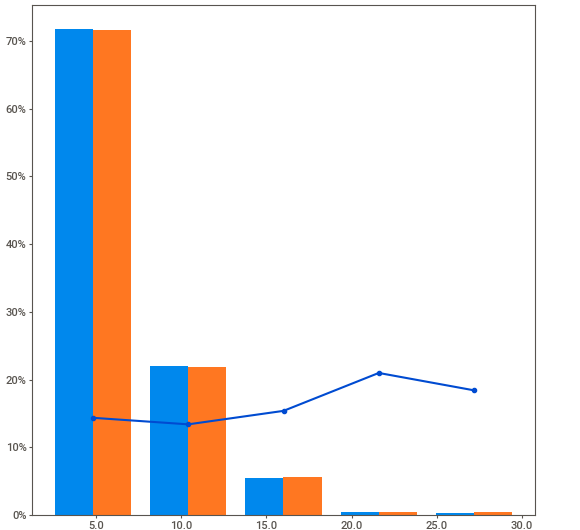
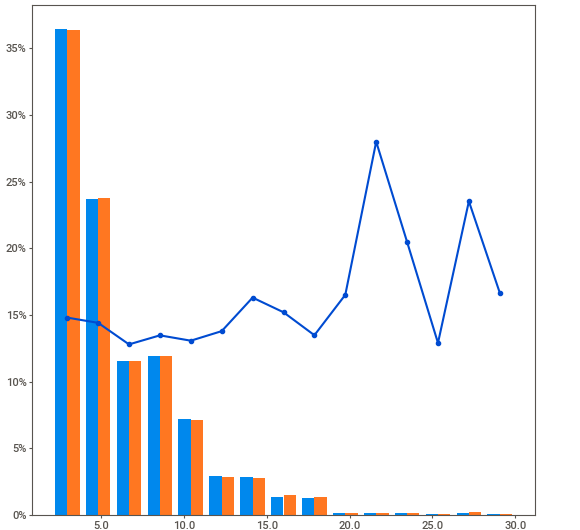
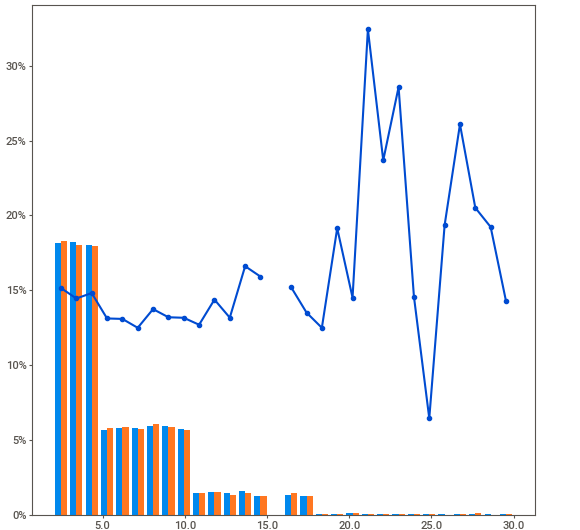
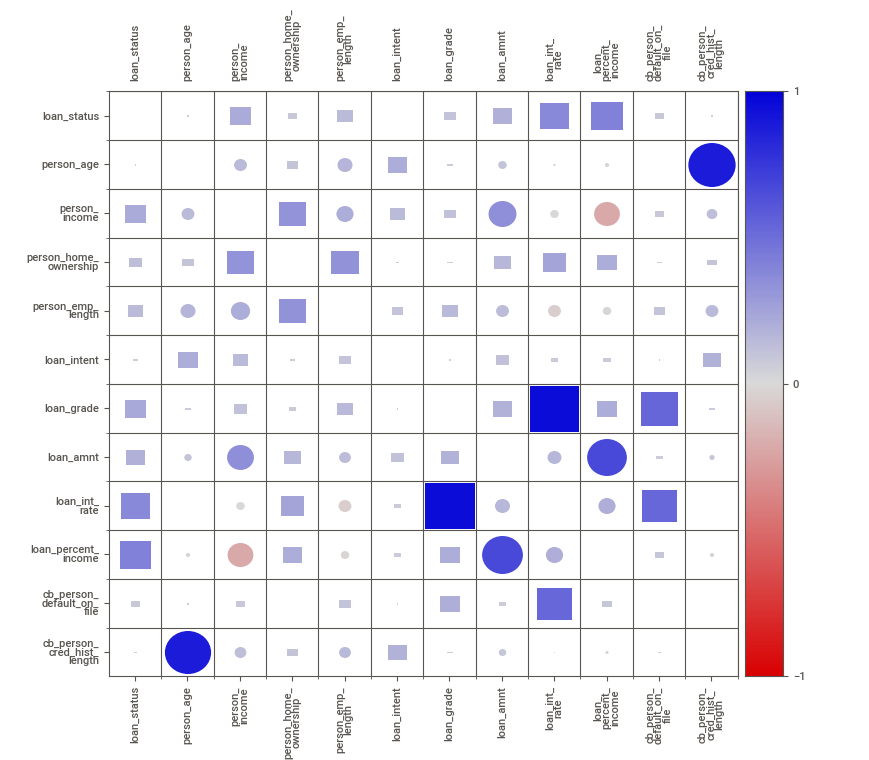
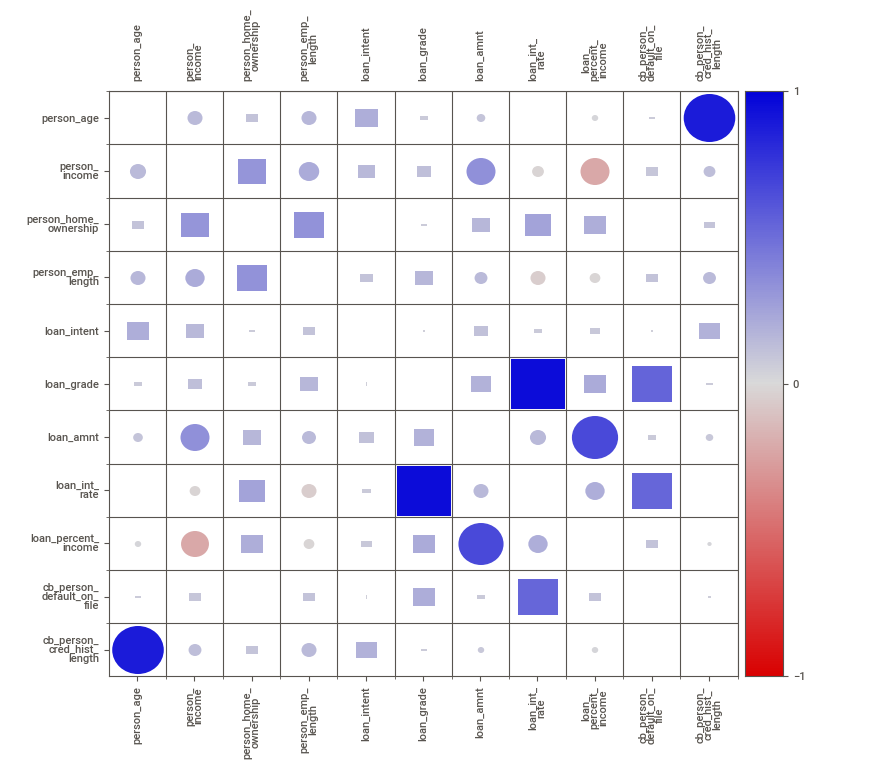

In [30]:
# Using Sweetviz to compare the training and testing datasets
sv_train_test = sv.compare(df_train, df_test, target_feat='loan_status')
sv_train_test.show_notebook(w='100%', h='full')

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="6"></a>
# **Data Preprocessing**

In [31]:
# Reloading in the datasets
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

In [32]:
# Creating function to preprocess (encode) and create new features
def preprocess(df):
    
    # Preprocessing/encoding object type features as int
    df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
    df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
    df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
    df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)
    df['person_emp_length'] = df['person_emp_length'].astype(int)
    df['loan_int_rate'] = (df['loan_int_rate'] * 100).astype(int)
    df['loan_percent_income'] = (df['loan_percent_income'] * 100).astype(int)
    
    # Feature engineering
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income'] 
    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate'] 
    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'])
    df['cred_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    df['int_to_loan_ratio'] = df['loan_int_rate'] / df['loan_amnt']
    df['loan_int_emp_interaction'] = df['loan_int_rate'] * df['person_emp_length']
    df['debt_to_credit_ratio'] = df['loan_amnt'] / df['cb_person_cred_hist_length'] 
    df['int_to_cred_hist'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']  
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'])
    df['loan_amt_per_emp_year'] = df['loan_amnt'] / (df['person_emp_length'])      
    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt'] 

# Applying preprocess function to train and test datasets    
preprocess(df_train)
preprocess(df_test)

In [33]:
# Verifying the changes made to the training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  int64  
 4   person_emp_length           58645 non-null  int64  
 5   loan_intent                 58645 non-null  int64  
 6   loan_grade                  58645 non-null  int64  
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  int64  
 9   loan_percent_income         58645 non-null  int64  
 10  cb_person_default_on_file   58645 non-null  int64  
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
 13  loan_to_income_ratio        586

In [34]:
# Setting up training and testing sets for the model
ID = df_test['id']
X_train = df_train.drop(['loan_status', 'id'], axis=1)
y_train = df_train['loan_status']
X_test = df_test.drop(['id'], axis=1)

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#8" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="7"></a>
# **LGBM Model w/ Optuna**

**Predetermined Parameters**

- 'objective': 'binary' --> the objective parameter is set to binary, as this is a binary classification problem
- 'device': 'cpu' --> we are relying solely on the cpu for this project, as it supports all LGBM functionality
- 'verbosity': -1 --> this lowers the verbosity (amount of text generated) of the LightGBM model
- 'boosting_type': 'gbdt' --> this sets the boosting type to traditional gradient boosting decision tree
- 'random_state': 42 --> this sets a random state which can be used for reproducing specific results


**Parameters Needed to be Optimized**

- 'num_leaves' --> this controls the maximum number of leaves in each tree, higher values create more complex trees but may overfit, lower values create simpler tree but may underfit
- 'learning_rate' --> the shrinkage rate, a smaller learning rate may improve accuracy but will also slow training
- 'n_estimators' --> essentially the number of boosting iterations
- 'subsample_for_bin' --> the number of data sampled to construct feature discrete bins, larger values may give better results
- 'reg_alpha' & 'reg_lambda' --> aliases for lambda_l1 & lambda_l2, L1 & L2 regularization
- 'max_depth' --> this limits the max depth of the tree model, deeper trees can capture more complex patterns but may also overfit
- 'colsample_bytree' --> this helps speed up training and potentially deal with over-fitting
- 'subsample' --> similar to "colsample_bytree" but randomly selects part of the data without resampling, can also be used to speed up training
- 'min_child_samples' --> the minimal number of data in one tree leaf, helps with over-fitting
- 'feature_fraction' --> the fraction of features used to train the decision tree, can help with over-fitting
- 'bagging_fraction' --> similar to feature fraction, can help speed up training and reduce over-fitting

In [35]:
# Defining the Optuna trial which will work to tune the parameters of the LGBM model

# Creating the objective for optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'device': 'cpu',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0)
    }
    
    # Fitting LGBM model with parameters from the trials
    model = LGBMClassifier(**params)
    # Stratified sampling 
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    cv_splits = cv.split(X_train, y_train)
    
    # Creating empty scores list to hold AUC scores from each trialed model
    scores = []
    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)
    
    # Printing and returning mean AUC scores
    mean_score = np.mean(scores)
    print(f"Mean ROC AUC Score = {mean_score:.5f}")
    return mean_score

# When set to 1, optuna will create a study to find the optimal parameters
run = 0

if run == 1:
    
    # Each optuna study uses an independent sampler with a TPE algorithm
    # For each trial, the TPE essentially uses Gaussian Mixture Models to identify the optimal parameter value
    study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
    study.optimize(objective, n_trials=100)
    print('Best value:', study.best_value)
    print('Best trial:', study.best_trial.params)

In [36]:
# Recording best parameters from trial above (FIRST VERSION)
best_params = {
    'num_leaves': 465, 
    'learning_rate': 0.04663603151769226, 
    'n_estimators': 777, 
    'subsample_for_bin': 195133, 
    'reg_alpha': 3.2248883860641223e-06, 
    'reg_lambda': 0.002493073926875983, 
    'max_depth': 4, 
    'colsample_bytree': 0.5916216317286411, 
    'subsample': 0.8972848131126971, 
    'min_child_samples': 23
    }

In [37]:
# Recording best parameters from trial above (SECOND VERSION)
best_params_2 = {
    'num_leaves': 301, 
    'learning_rate': 0.030842070949044974, 
    'n_estimators': 921, 
    'subsample_for_bin': 128087, 
    'reg_alpha': 0.08543291154990179, 
    'reg_lambda': 3.9292955013618704, 
    'max_depth': 6, 
    'colsample_bytree': 0.6857619348039488, 
    'subsample': 0.7774078680670069, 
    'min_child_samples': 44, 
    'feature_fraction': 0.5288157389802886, 
    'bagging_fraction': 0.6226401151972283
}

In [38]:
# Fitting the model with the best parameters!
final_model = LGBMClassifier(**best_params_2, verbosity=-1)

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#9" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="8"></a>
# **Model Evaluation**

In [39]:
# Obtaining final mean AUC score, using stratified sampling again
cv = StratifiedKFold(5, shuffle=True, random_state=42)
cv_splits = tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc='CV Progress')

scores = []
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    final_model.fit(X_train_fold, y_train_fold)
    y_pred_proba = final_model.predict_proba(X_val_fold)[:, 1]
    score = roc_auc_score(y_val_fold, y_pred_proba)
    scores.append(score)
    
    print(f'score: {score:.5f}')

print(f"Mean Score ＝ {np.mean(scores):.5f}") 

CV Progress:  20%|██        | 1/5 [00:09<00:39,  9.85s/it]

score: 0.95133


CV Progress:  40%|████      | 2/5 [00:20<00:31, 10.46s/it]

score: 0.96168


CV Progress:  60%|██████    | 3/5 [00:30<00:19,  9.97s/it]

score: 0.95374


CV Progress:  80%|████████  | 4/5 [00:39<00:09,  9.75s/it]

score: 0.95990


CV Progress: 100%|██████████| 5/5 [00:48<00:00,  9.78s/it]

score: 0.95820
Mean Score ＝ 0.95697


0.95710

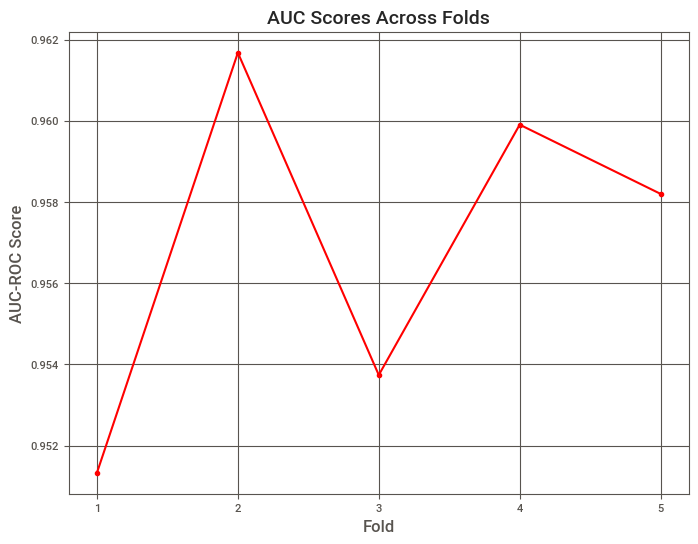

In [40]:
# Visualizing AUC scores across folds
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='r')
plt.title("AUC Scores Across Folds", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("AUC-ROC Score", fontsize=12)
plt.grid(True)
plt.xticks(range(1, len(scores) + 1))
plt.show()

In [41]:
# Making predictions on the test data, using the final model
predictions = final_model.predict_proba(X_test)[:, 1]

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

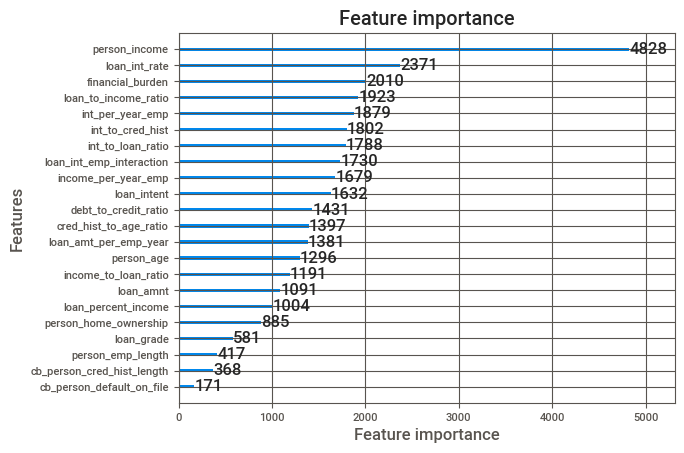

In [42]:
# Viewing feature importance
plot_importance(final_model)

<Axes: >

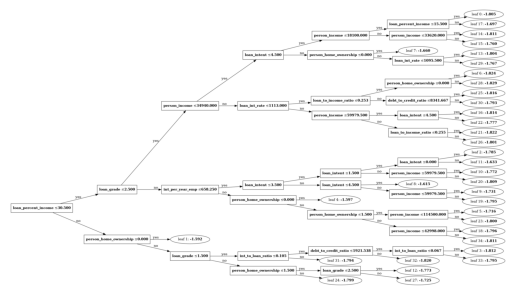

In [43]:
# Viewing model tree
lightgbm.plot_tree(final_model)

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="9"></a>
# **Submission**

In [44]:
# Applying final predictions to submission dataset
submission = pd.DataFrame({"id": ID, "loan_status": predictions})
submission

id  loan_status
0      58645     0.996885
1      58646     0.016405
2      58647     0.551596
3      58648     0.007186
4      58649     0.073894
...      ...          ...
39093  97738     0.092316
39094  97739     0.003405
39095  97740     0.019009
39096  97741     0.393356
39097  97742     0.963597

[39098 rows x 2 columns]

In [45]:
# Creating .csv file for submissions and scoring
run = 1

if run == 1:
    submission.to_csv('submission.csv', index=False)

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="r"></a>
# **References**

- https://www.kaggle.com/competitions/playground-series-s4e10/overview
- https://github.com/microsoft/LightGBM
- https://optuna.org/
- https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction
- https://towardsdatascience.com/adversarial-validation-ca69303543cd
- https://www.machinelearningexpedition.com/lightgbm-hyperparameter-tuning/
- https://lightgbm.readthedocs.io/en/latest/Parameters.html
- https://pypi.org/project/sweetviz/